In [67]:
# Analisi dati 
import pandas as pd 
import matplotlib.pyplot as plt  
import plotly.express as px
import numpy as np

# Machine learning 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier,  export_text
from sklearn import metrics 
from sklearn.tree import plot_tree


### Pulizia dati

In [2]:
# carico il dataset fornito dal professore
file_csv = "C:/Users/ettor/OneDrive/Documenti/UNITN - TRIENNALE/CORSI/3 anno, 1 SEM/Marketing/LL/LL_3_Session/Input/QUESTIONARIO_Cinema.csv"
ds_cin = pd.read_csv(file_csv, encoding='latin-1')

In [3]:
# elimino una colonna con dati imprecisi e superflui
ds_cin = ds_cin.drop('F', axis = 1)

In [4]:
# creo una nuova colonna più chiara per il genere
def genere(valore):
    if valore == 0:
        valore = 'Femmina'
        return valore
    else:
        valore = 'Maschio'
        return valore 

nuova_colonna = ds_cin['M'].apply(genere)
ds_cin.insert(1, 'Genere', nuova_colonna)

In [5]:
# elimino da ogni colonna i valori non riconosciti dall'encoding Latin
for i in ds_cin.columns[1:]:
    ds_cin[i] = ds_cin[i].str.replace(r'[^a-zA-Z0-9]', ' ', regex = True)

In [6]:
# elimino i valori nulli nel dataset
ds_cin = ds_cin.dropna()

In [7]:
# elimino i valori non numerici dalla colonna fascia di età
ds_cin['Fascia di eta'] = ds_cin['Fascia di eta'].str.replace(r'[^0-9]', '', regex = True)

In [8]:
# creo un'intervallo 50-50 per i valori di età 'oltre i 50'
def aggiungi(valore):
    
    if valore == '50':
        return '50' + valore 
    else:
        return valore

ds_cin['Fascia di eta'] = ds_cin['Fascia di eta'].apply(aggiungi)

In [9]:
# modifico le celle di fascia di età per renderle codificabili
ds_cin['Fascia di eta'] = ds_cin['Fascia di eta'].str[:2] + ',' + ds_cin['Fascia di eta'].str[2:]

In [10]:
# costruisco una colonna che al posto di avere l'intervallo di età
# ha l'età media di ogni consumatore
def calcola_media(valori):
    
    valore_splitted = valori.split(',')
    valore1 = float(valore_splitted[0])
    valore2 = float(valore_splitted[1])
    media = (valore1 + valore2) / 2
    
    return media

nuova_colonna = ds_cin['Fascia di eta'].apply(calcola_media)
ds_cin.insert(2, 'Eta media', nuova_colonna)
ds_cin['Eta media'] = ds_cin['Eta media'].astype(str)
ds_cin = ds_cin.drop('Fascia di eta', axis = 1)

In [11]:
# pulizia dati
ds_cin['Numero dei componenti nucleo familiare'] = ds_cin['Numero dei componenti nucleo familiare'].str.replace('pi', 'Più', regex = True)
ds_cin['Numero medio di film visti al cinema ogni mese'] = ds_cin['Numero medio di film visti al cinema ogni mese'].str.replace('Pi', 'Più', regex = True)
ds_cin['Numero medio di libri letti in un anno'] = ds_cin['Numero medio di libri letti in un anno'].str.replace('Pi', 'Più', regex = True)
ds_cin['Numero medio di concerti visti in un anno'] = ds_cin['Numero medio di concerti visti in un anno'].str.replace('Pi', 'Più', regex = True)
ds_cin['Numero medio di mostre viste in un anno'] = ds_cin['Numero medio di mostre viste in un anno'].str.replace('Pi', 'Più', regex = True)
ds_cin['Numero medio di musei visitati in un anno'] = ds_cin['Numero medio di musei visitati in un anno'].str.replace('Pi', 'Più', regex = True)
ds_cin['Numero medio di rappresentazioni teatrali viste in un anno'] = ds_cin['Numero medio di rappresentazioni teatrali viste in un anno'].str.replace('Pi', 'Più', regex = True)

### Categorizzazione dati e plot grafici distribuzioni features 

In [12]:
# categorizzazione dei dataset per scelta della sala, lo usiamo dopo per i grafici
ds_cin_UCI = ds_cin[ds_cin['Sala cinematografica di riferimento'] == 'UCI']
ds_cin_TS = ds_cin[ds_cin['Sala cinematografica di riferimento'] == 'The Space']
ds_cin_other = ds_cin[ds_cin['Sala cinematografica di riferimento'] == 'Altra']
lista_cinema = [ds_cin_UCI, ds_cin_TS, ds_cin_other]

In [13]:
# algoritmo di ricerca delle stringhe: obiettivo ritornare una lista di lista, con una copia singola 
# delle stringhe di ogni colonna. 

ds_loop = ds_cin.drop(['M', 'Sala cinematografica di riferimento'], axis = 1)

stringa = ' '
lista_stringhe = []

for i, df in enumerate(ds_loop):
    
        lista_stringhe.append([])

        for cella in ds_cin[df]:
        
             if cella != stringa and cella not in lista_stringhe[i]:        
                
                stringa = cella 
                lista_stringhe[i].append(stringa)

In [14]:
# altro lista di colonne utile per loop
dm = ds_cin.drop(['M','Sala cinematografica di riferimento'], axis = 1)

In [15]:
# creiamo una matrice di somme per avere tutti i dati impacchettati 
matrice_somme = []

for i, df in enumerate(lista_cinema):
    matrice_somme.append([])
    
    for n, lista_dentro_lista in enumerate(lista_stringhe):
        matrice_somme[i].append([])
        
        for stringax in lista_dentro_lista:
                
            conteggio = df[dm.columns[n]].str.count(stringax).sum()
            matrice_somme[i][n].append(conteggio)

In [16]:
# creo una feature utile per plottare i titoli nei grafici
titoli = []
for titolo in lista_cinema:
    titoli.append(titolo['Sala cinematografica di riferimento'].iloc[0])

In [17]:
# un altra feature per le label 
lista_label = []
for df_label in dm.columns:
    lista_label.append(df_label)

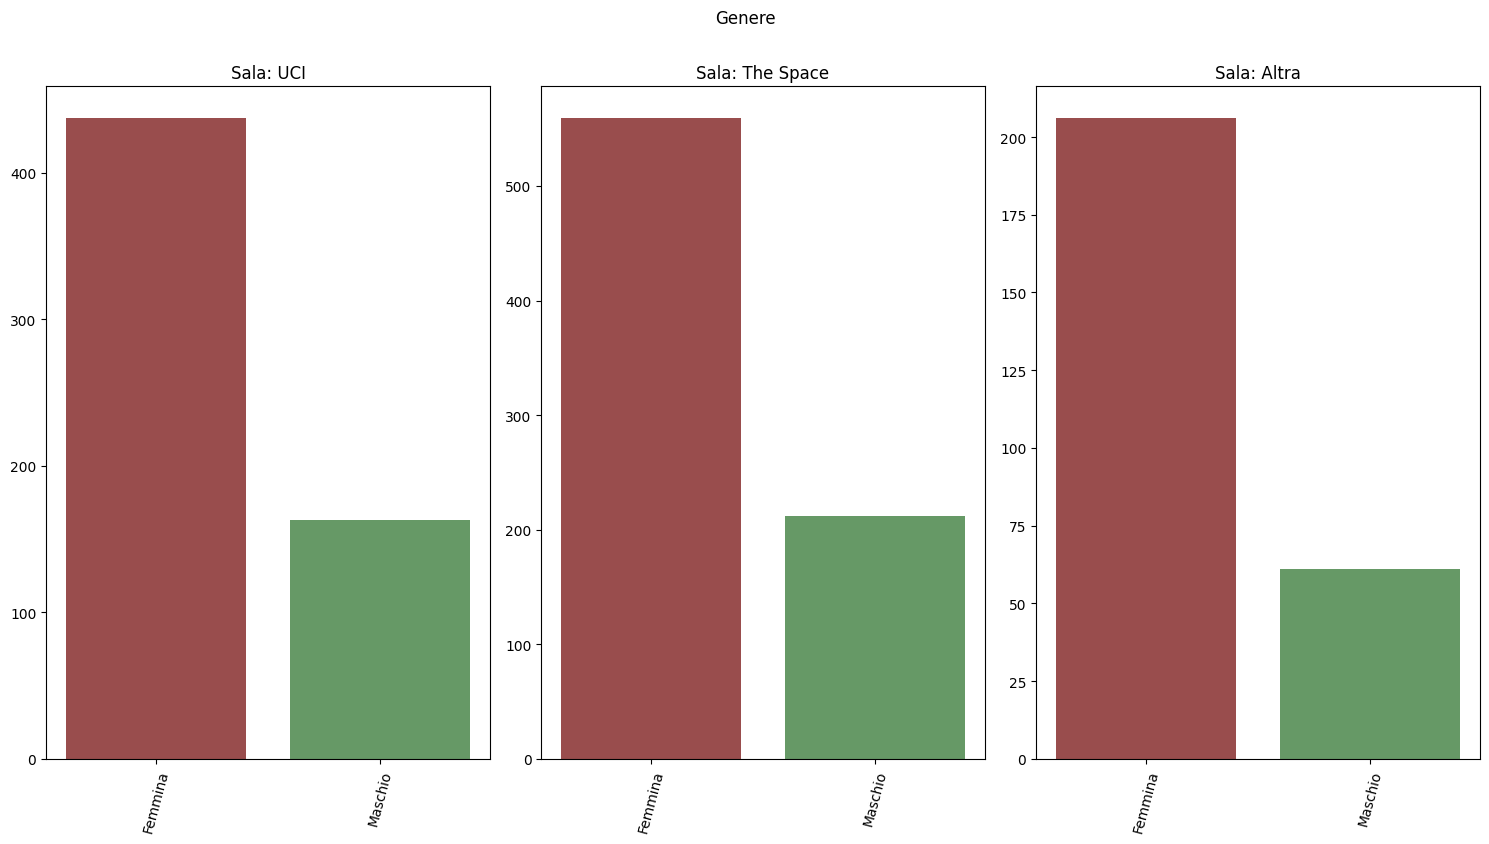

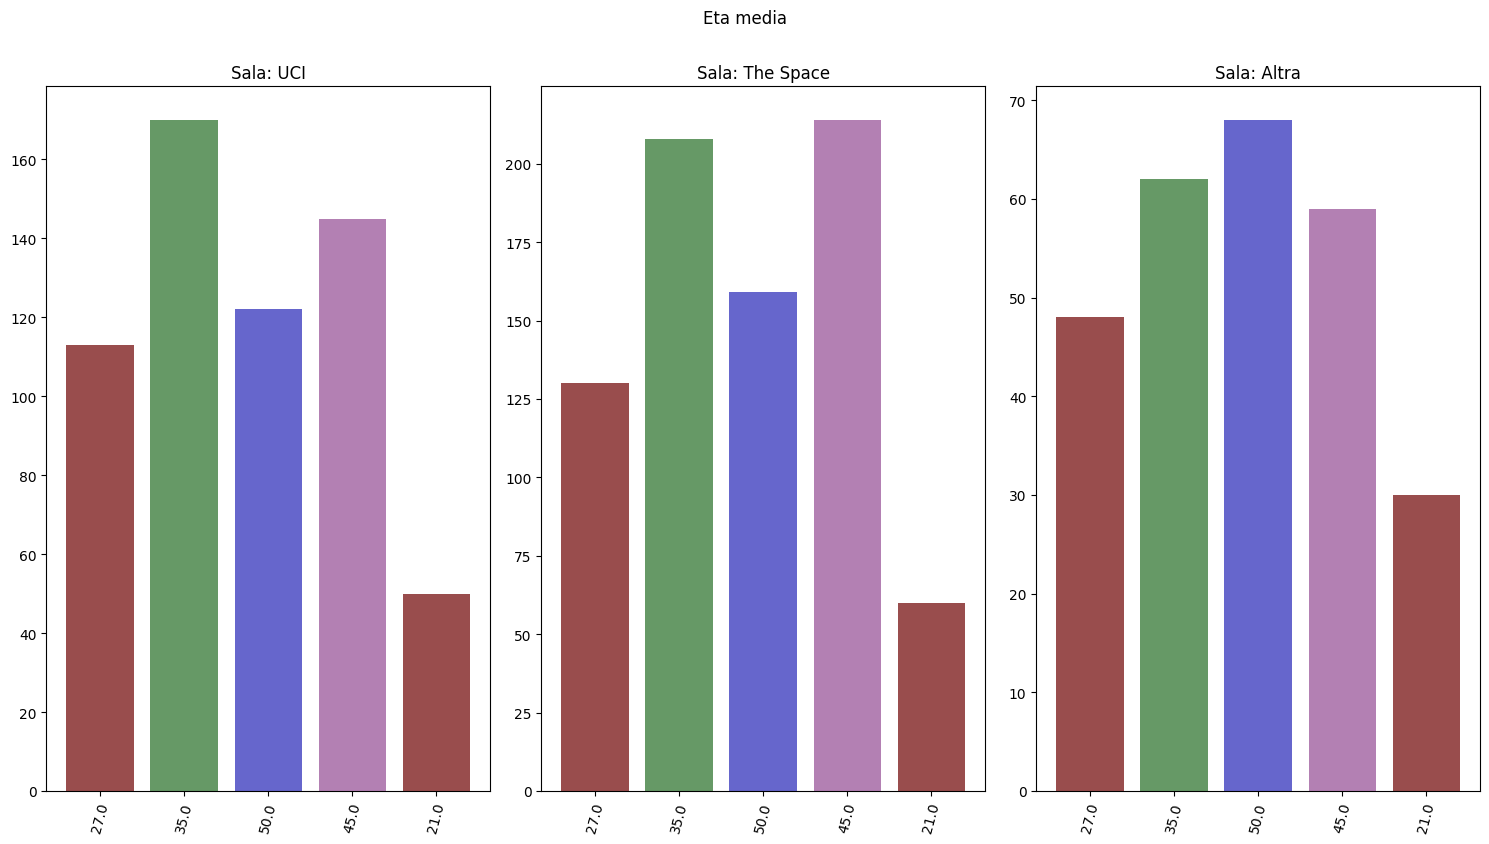

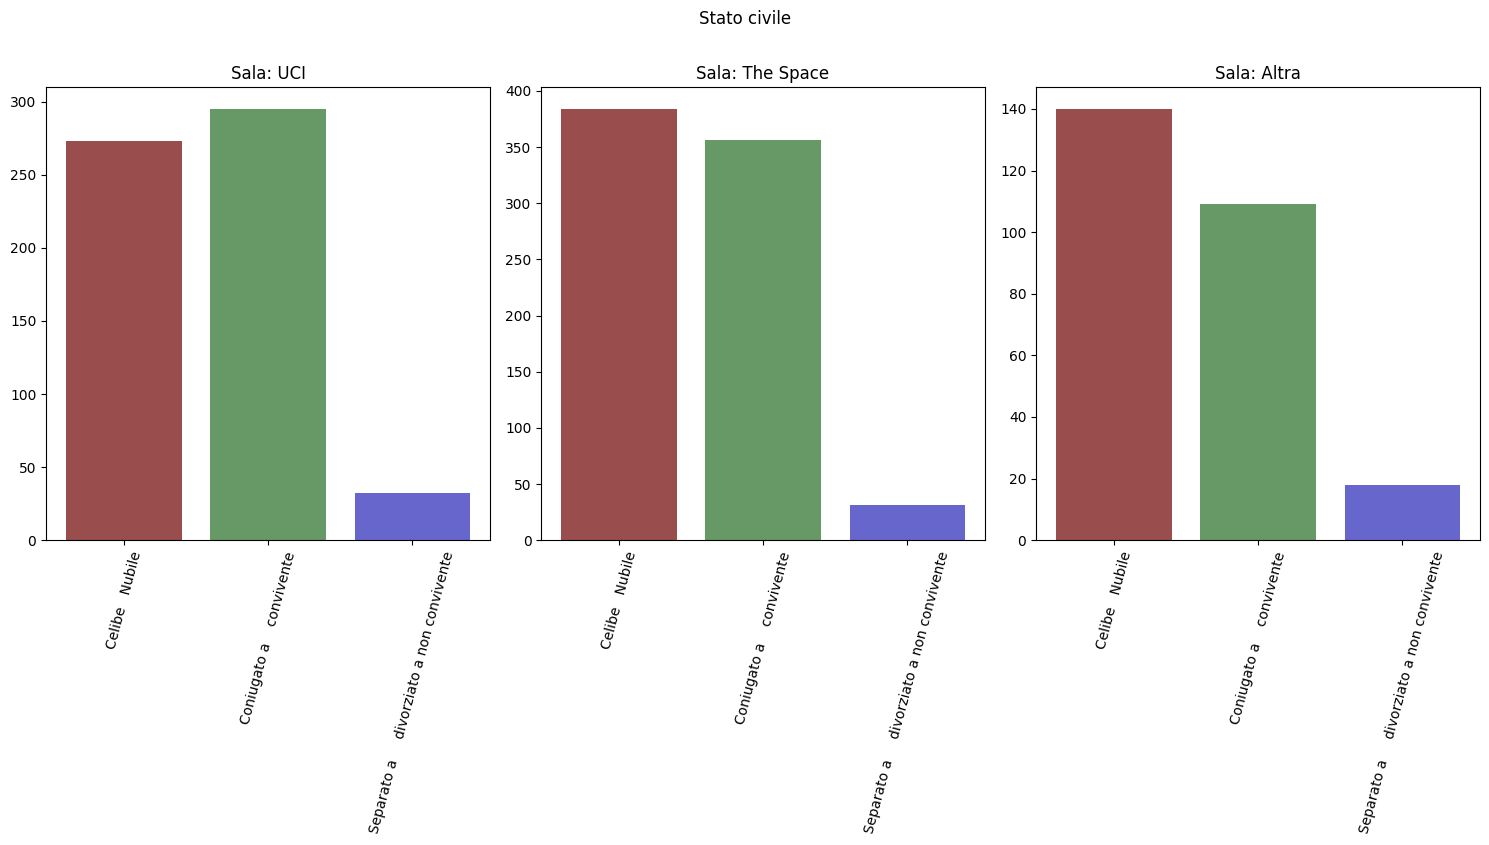

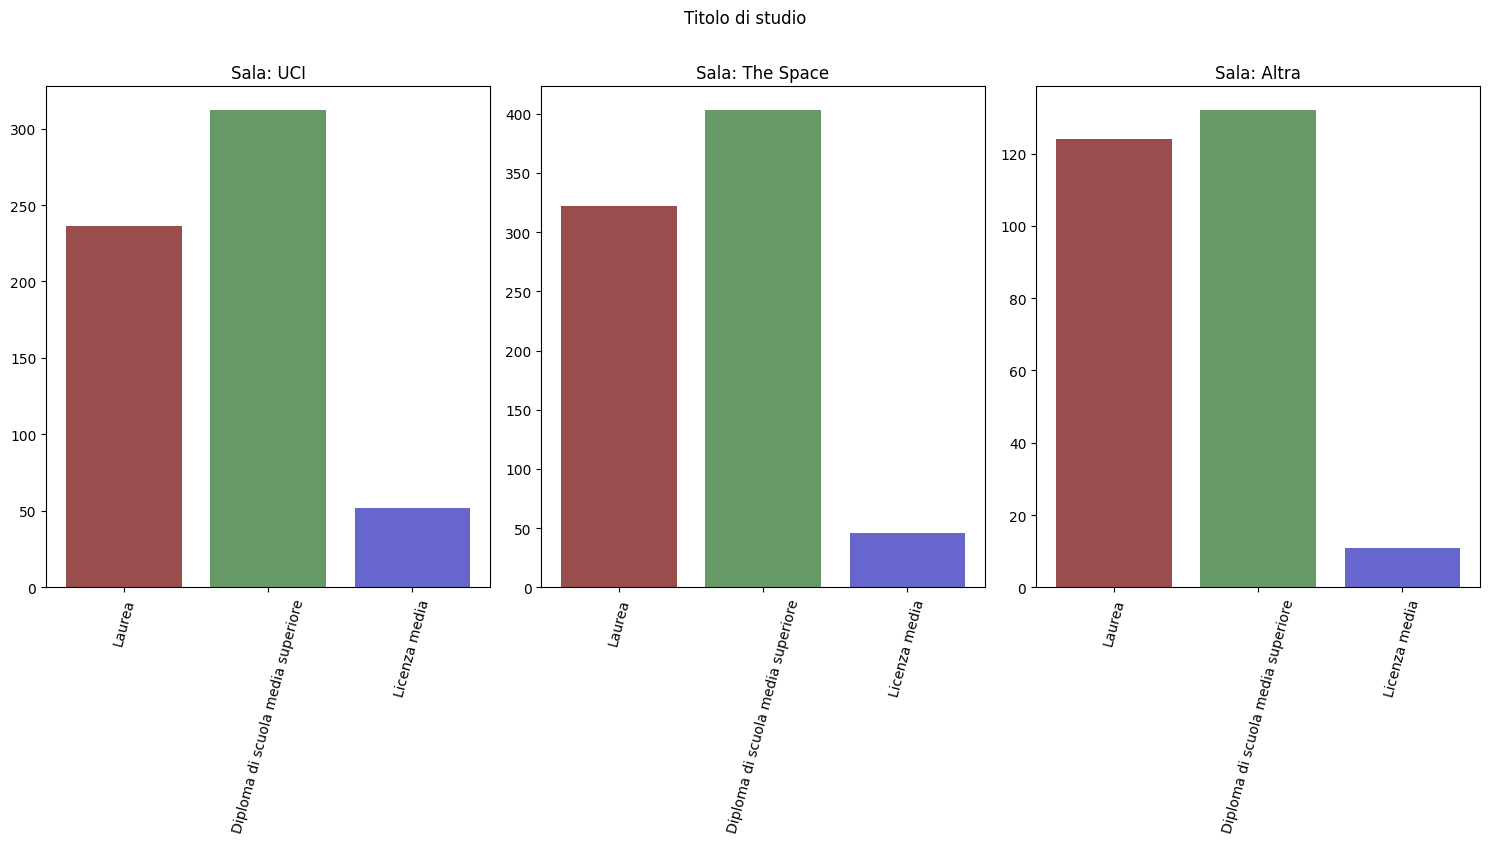

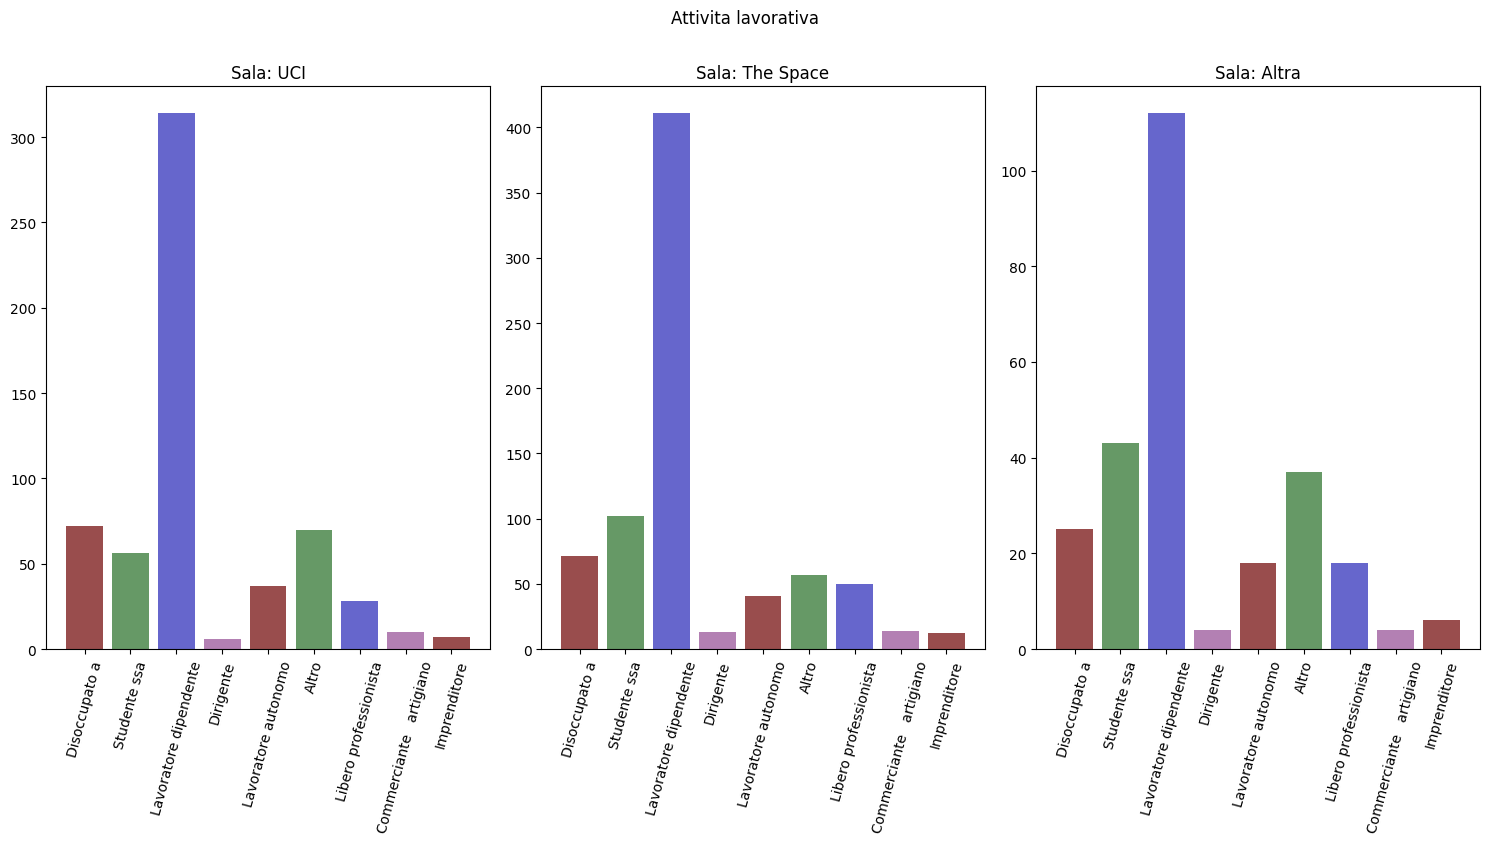

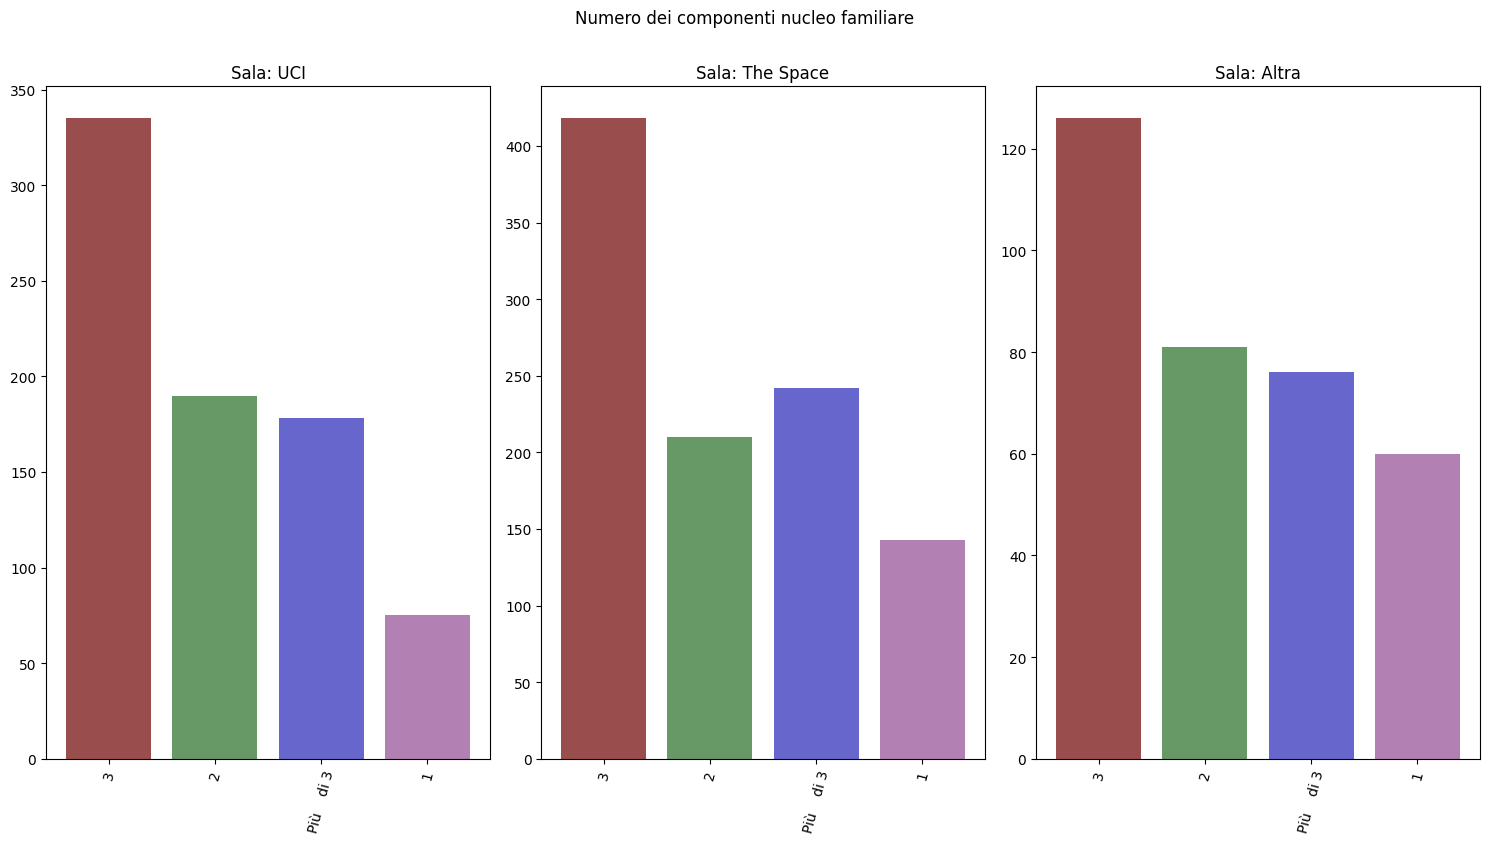

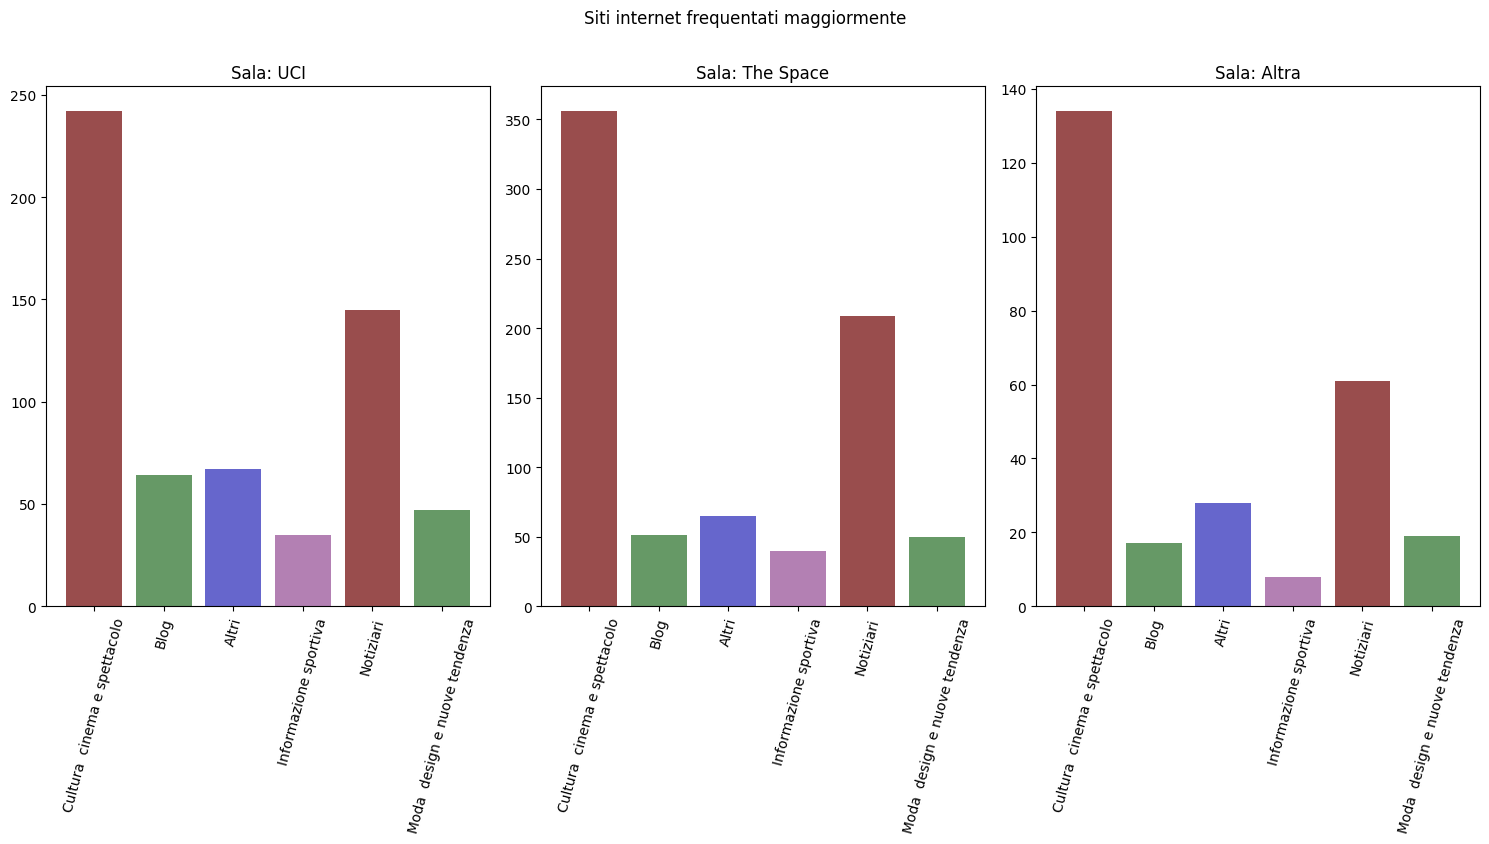

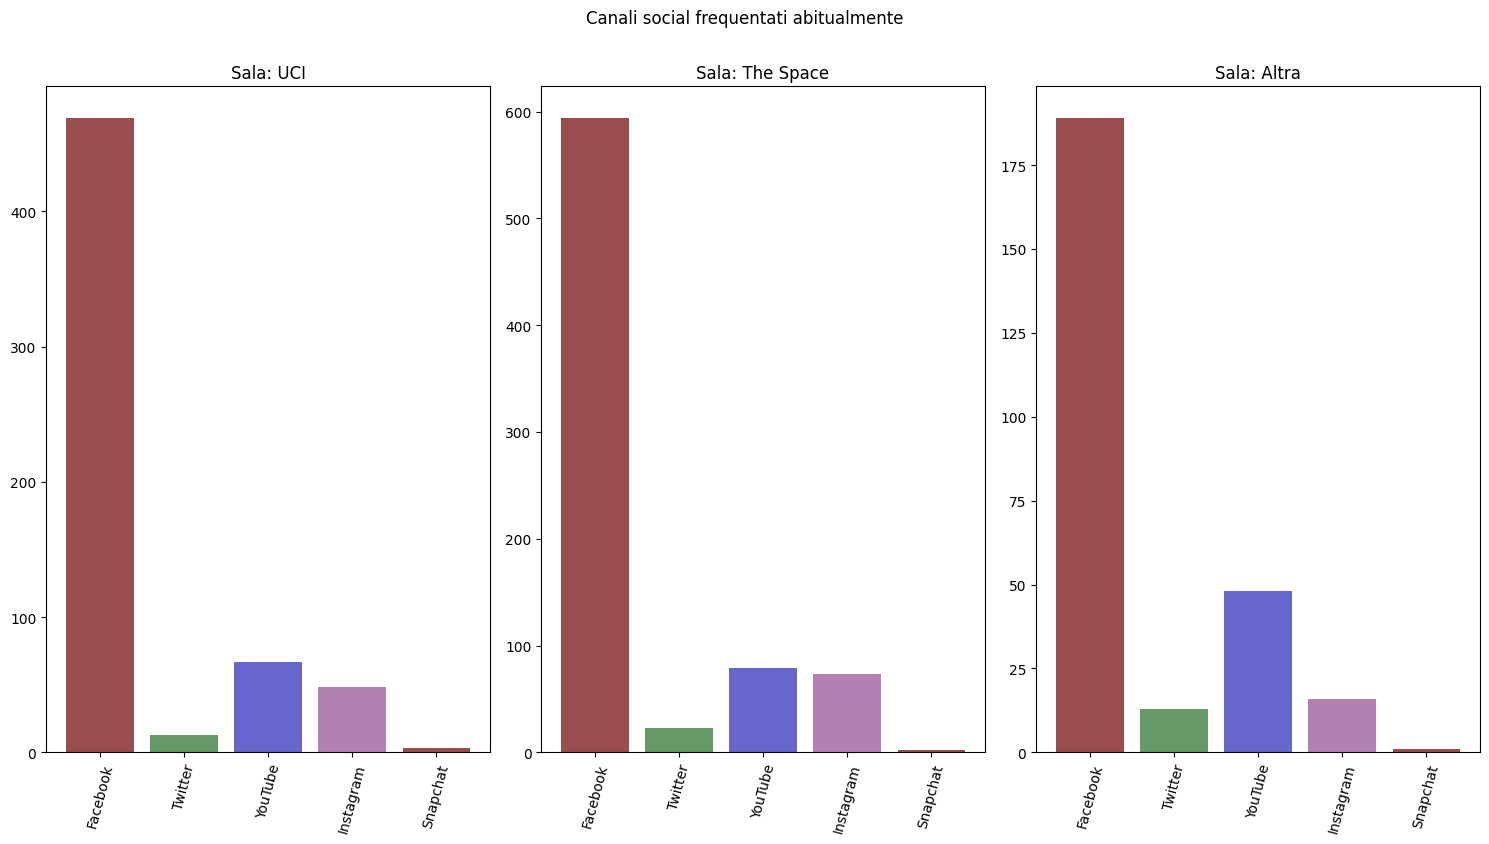

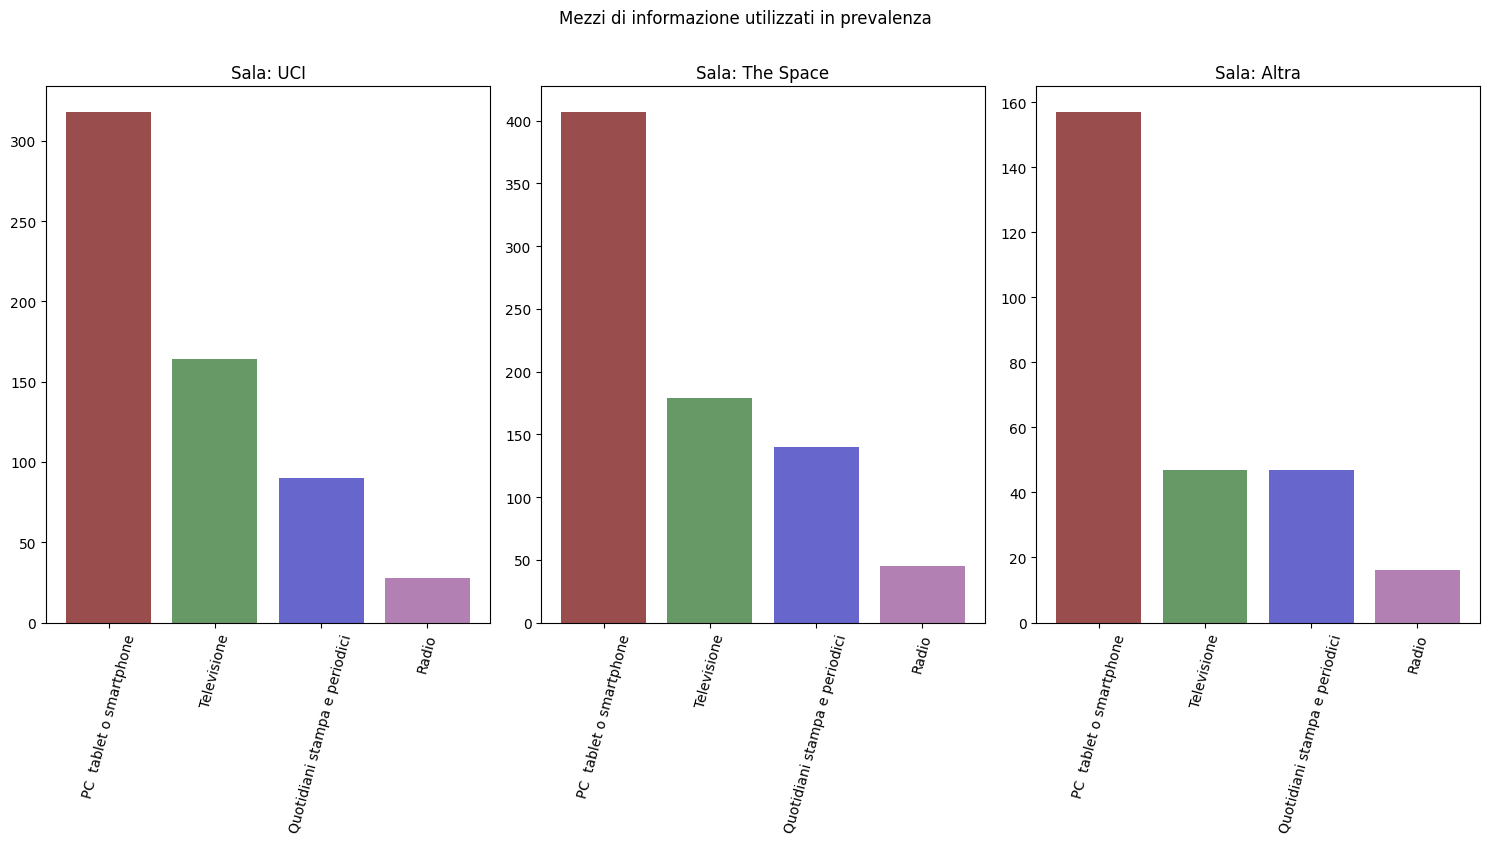

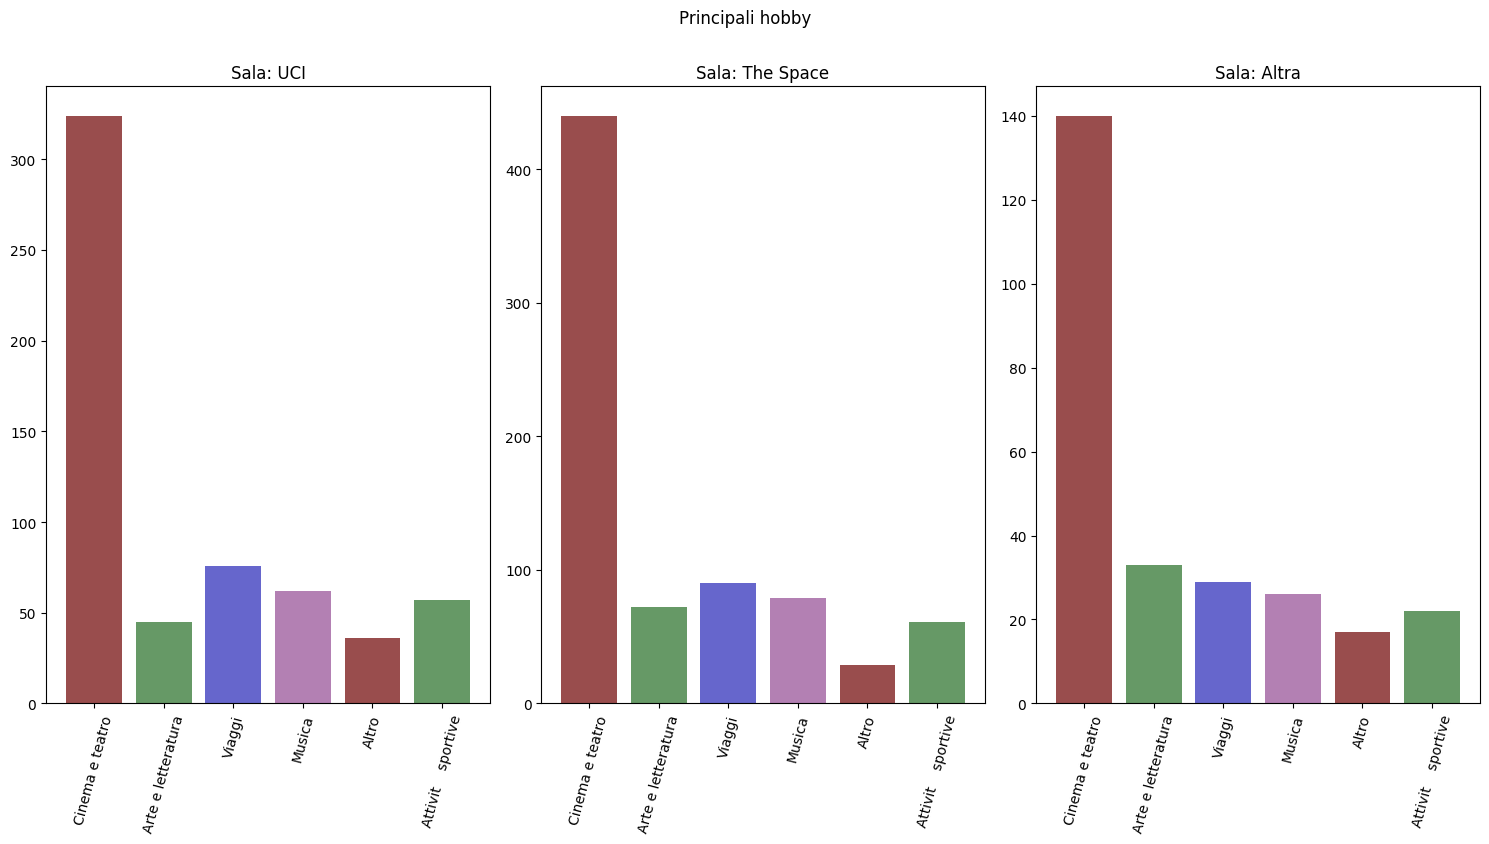

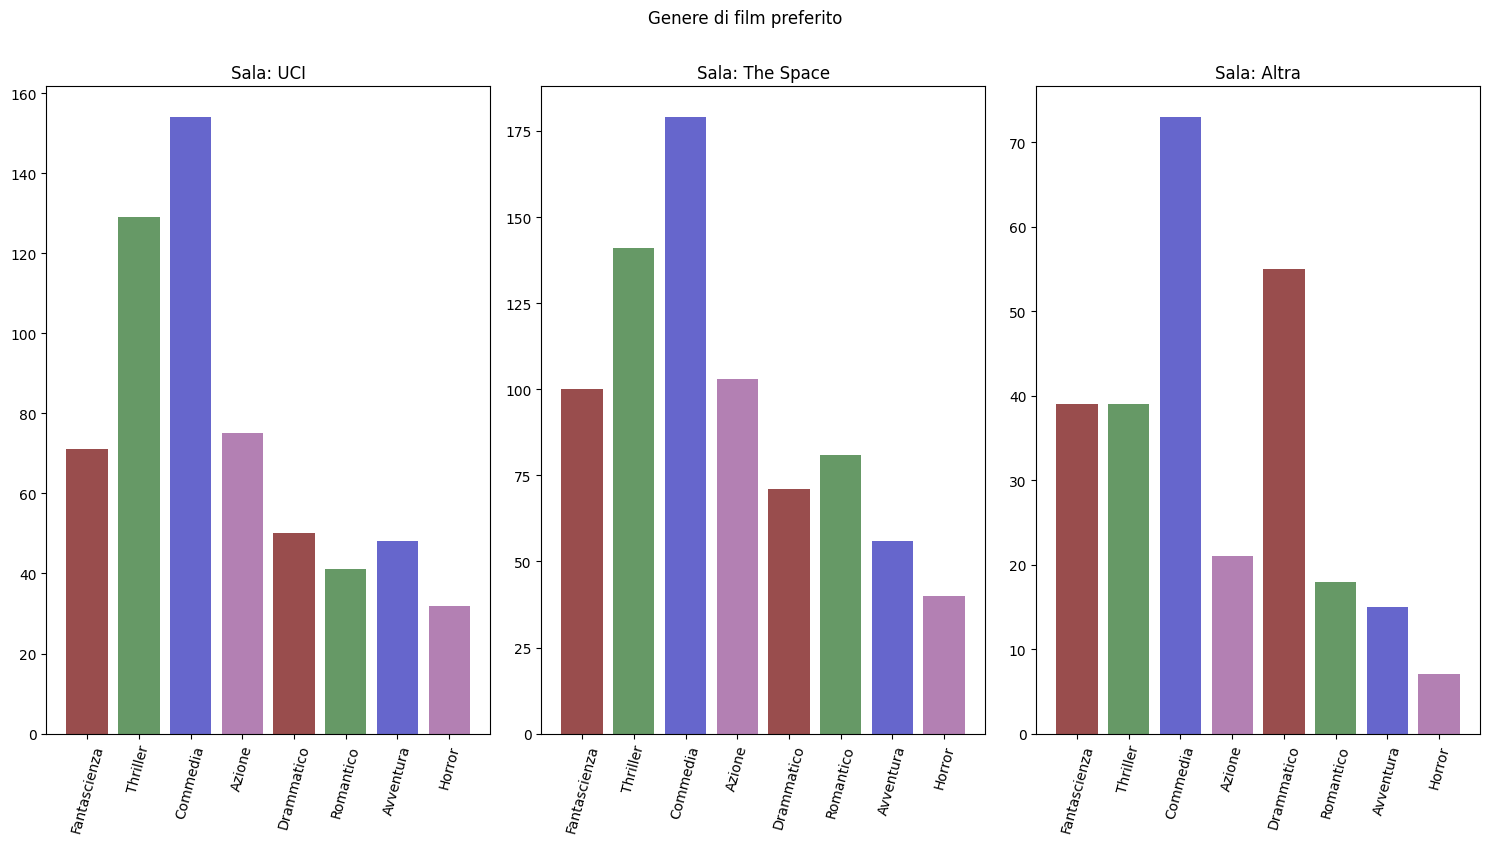

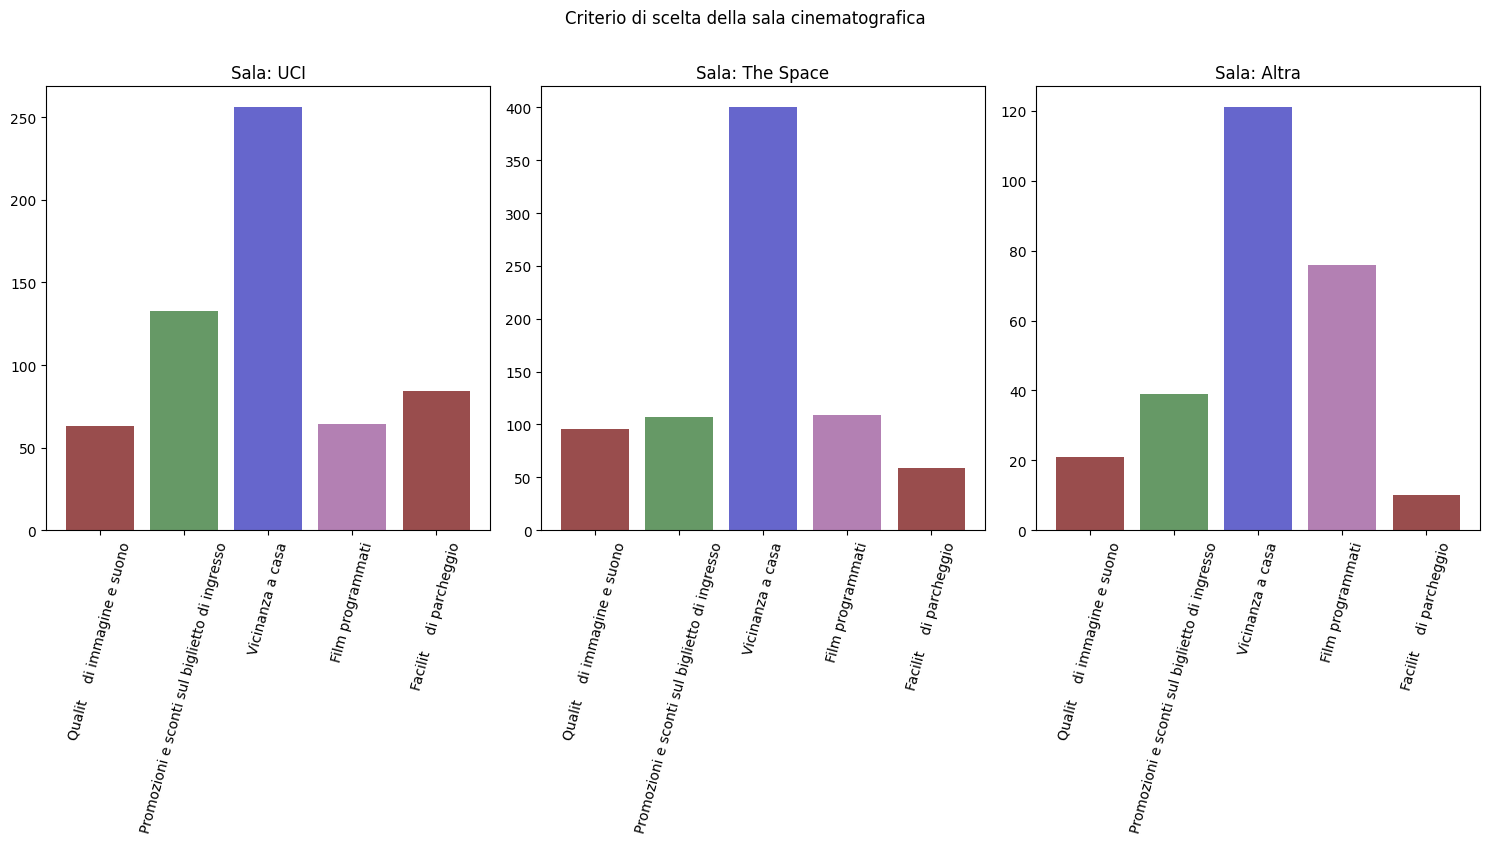

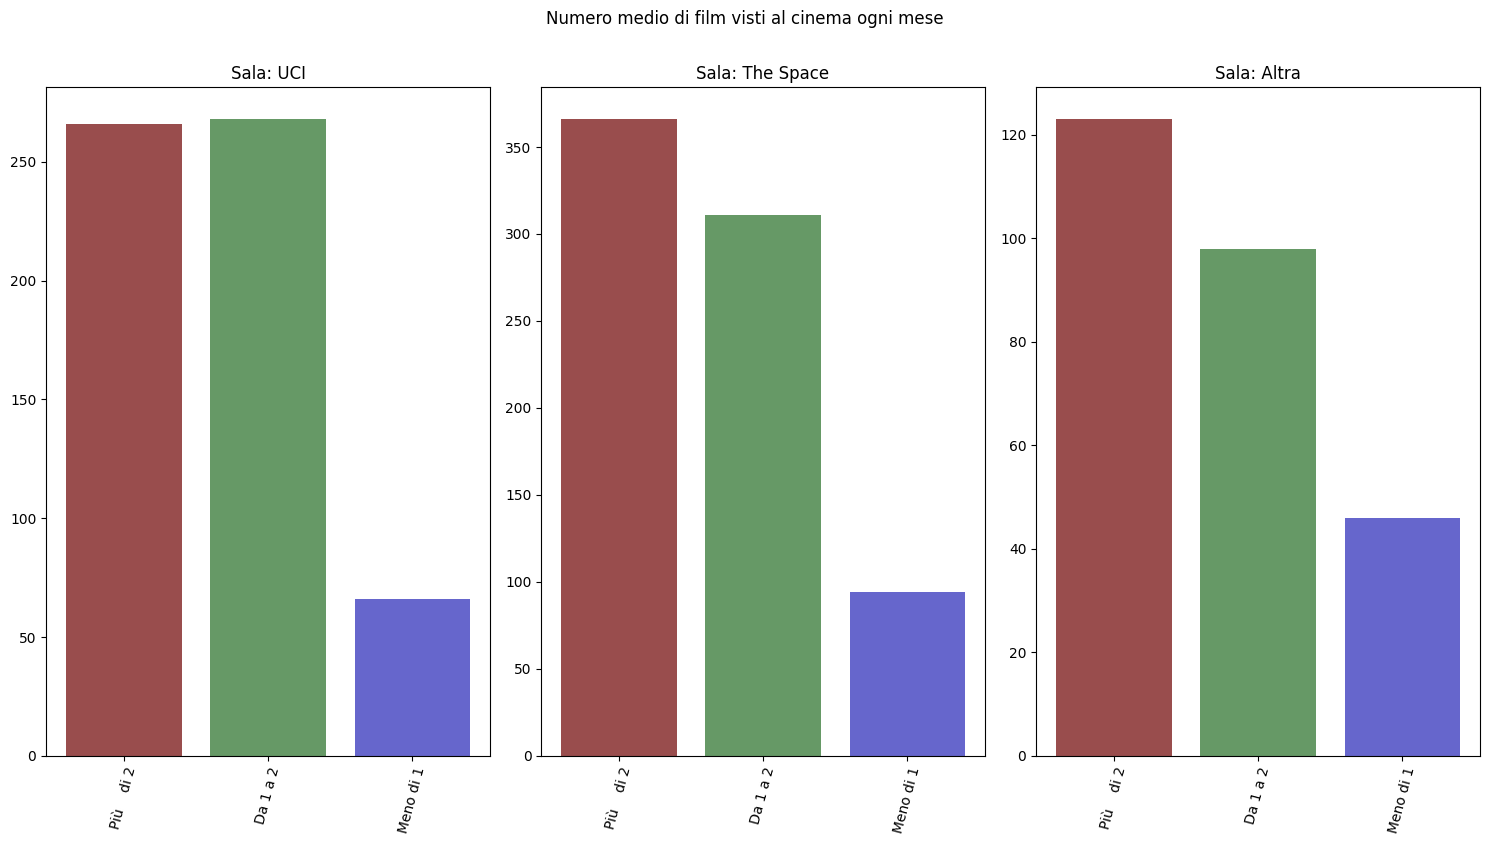

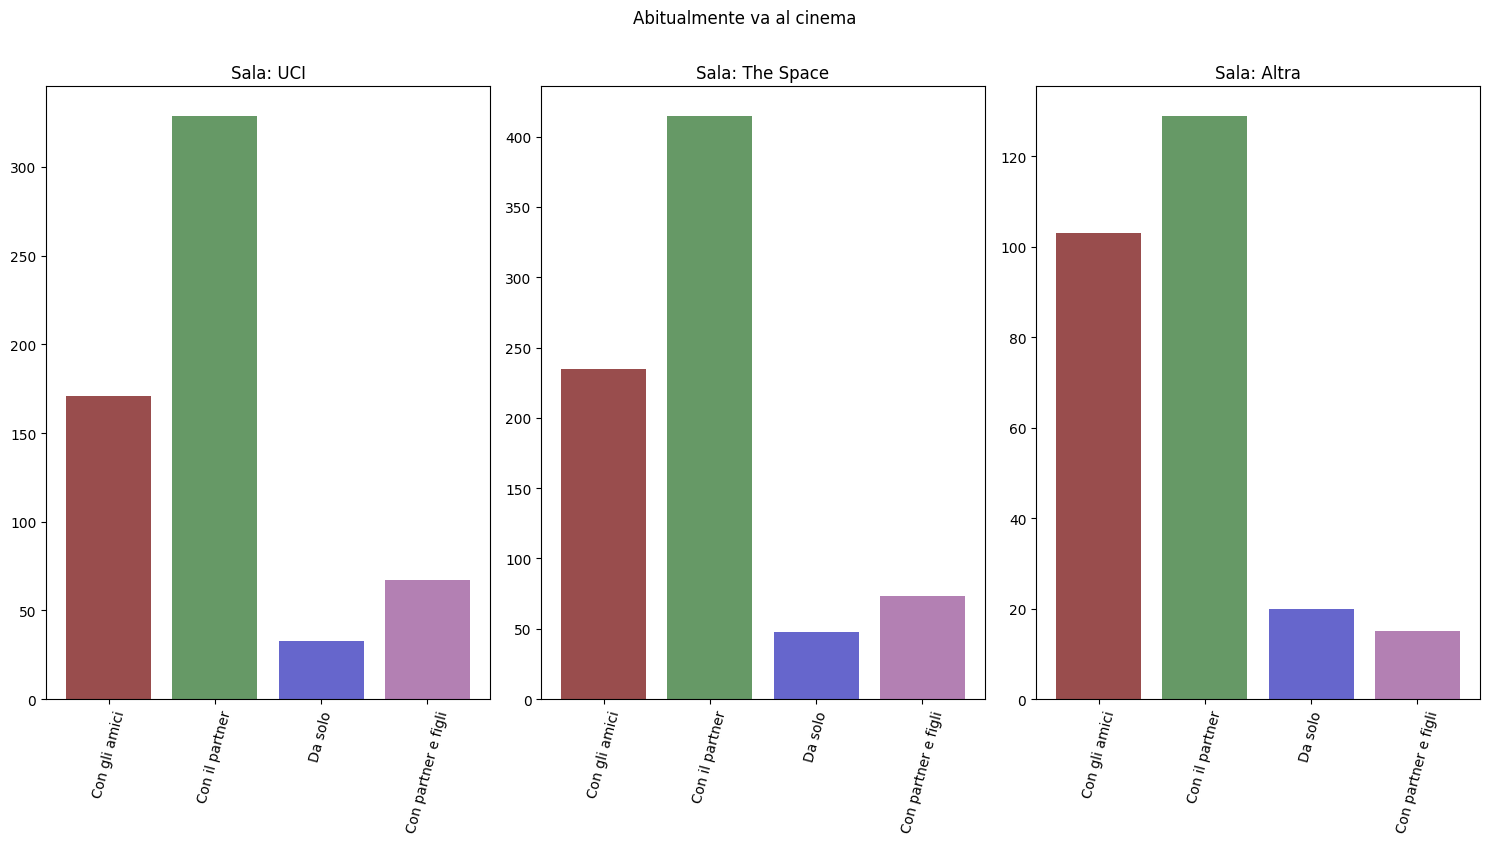

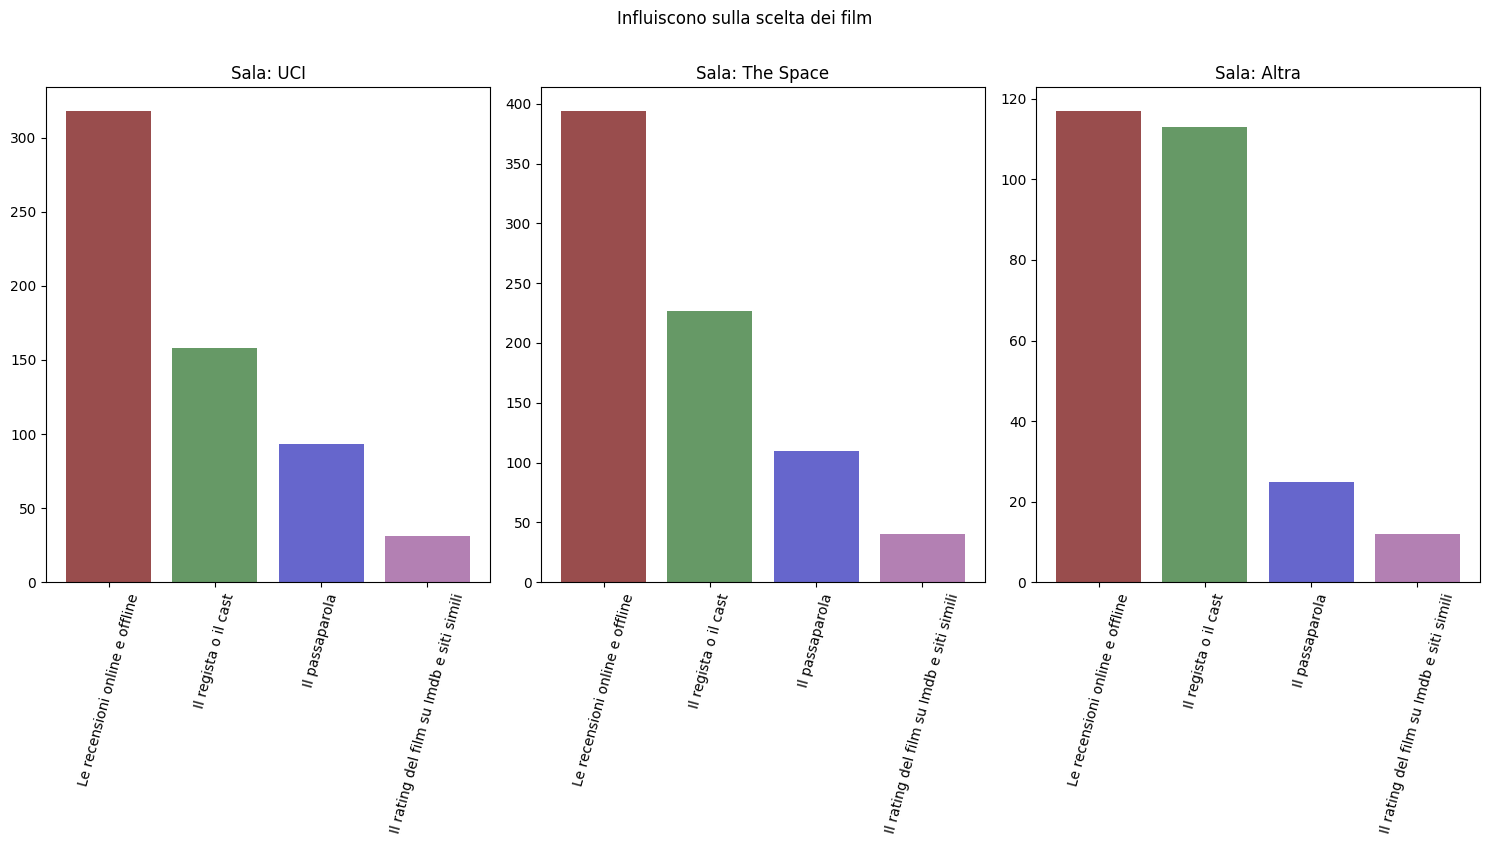

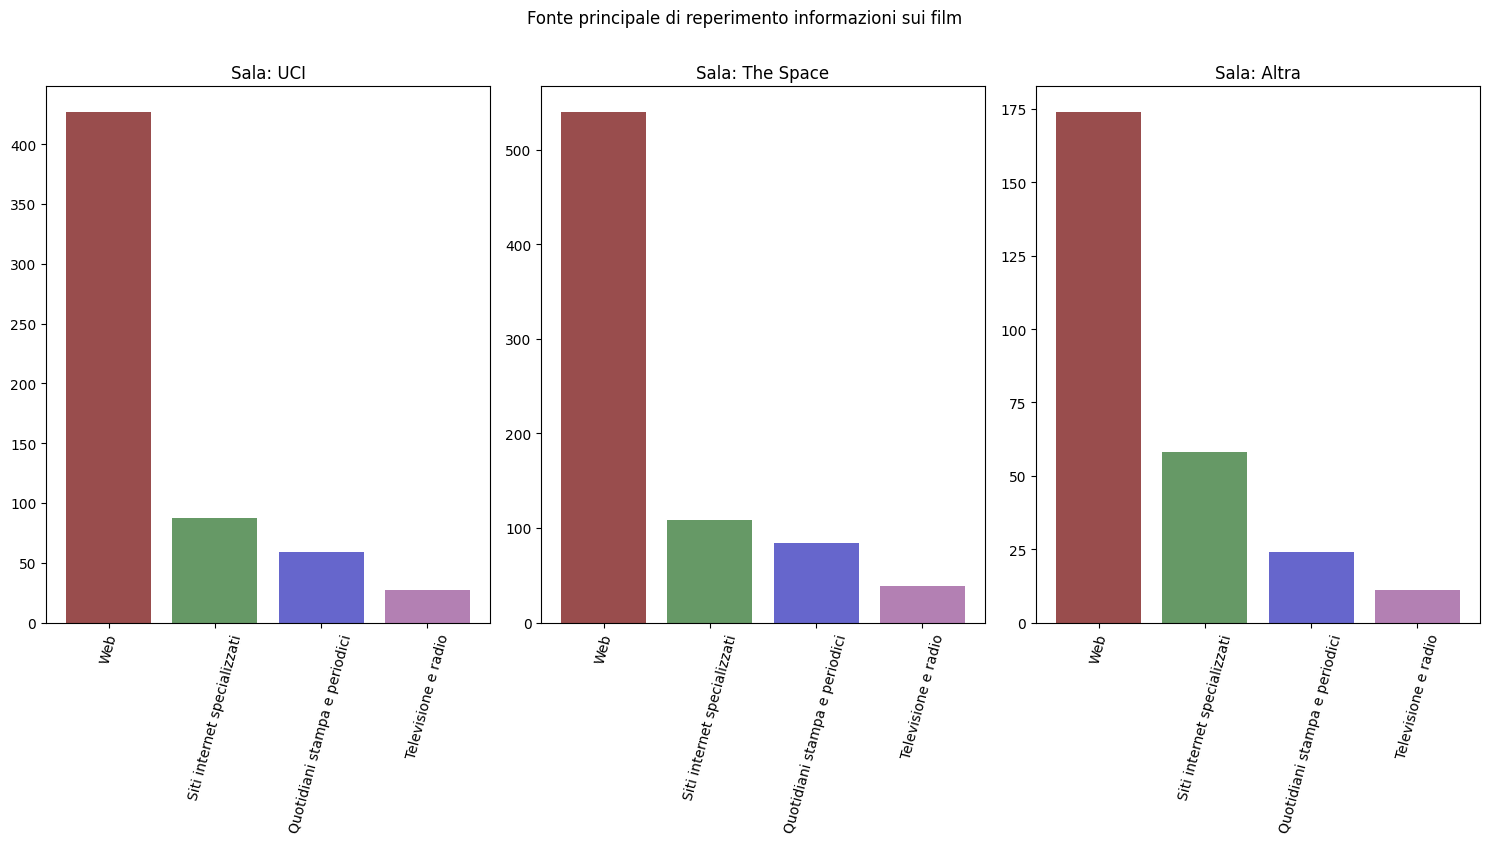

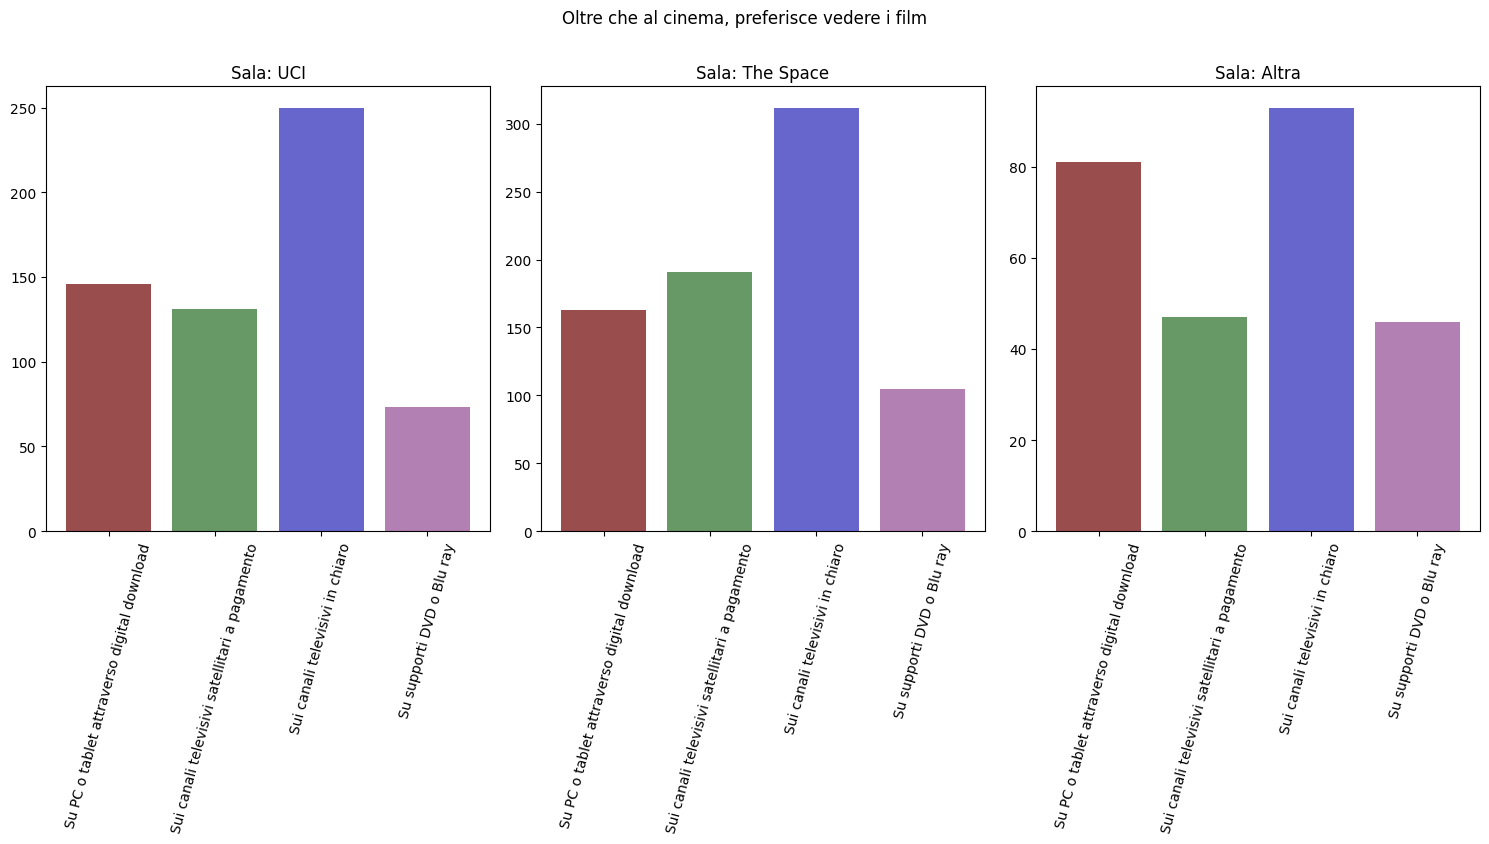

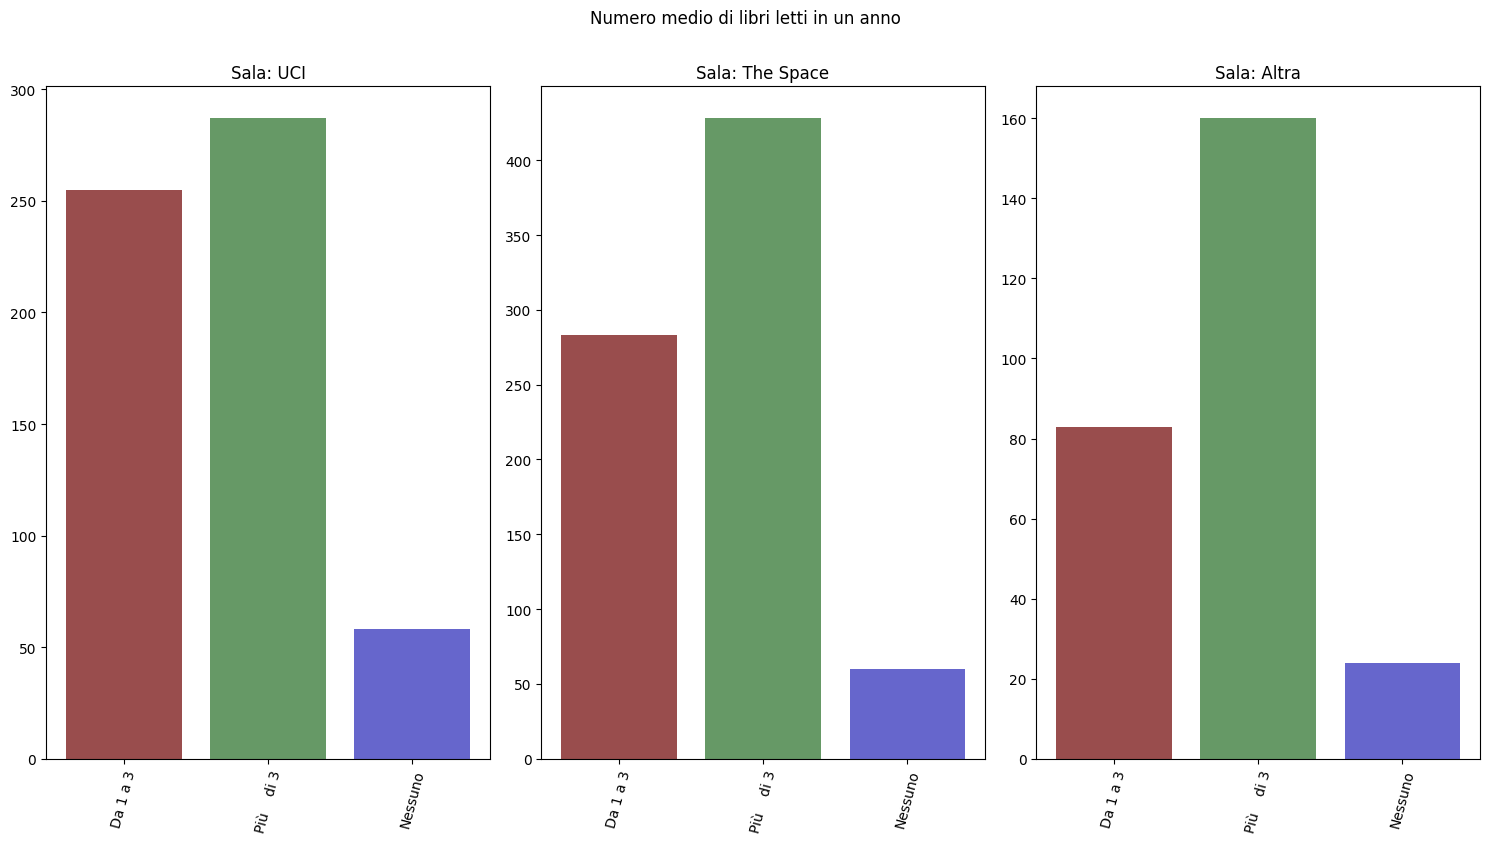

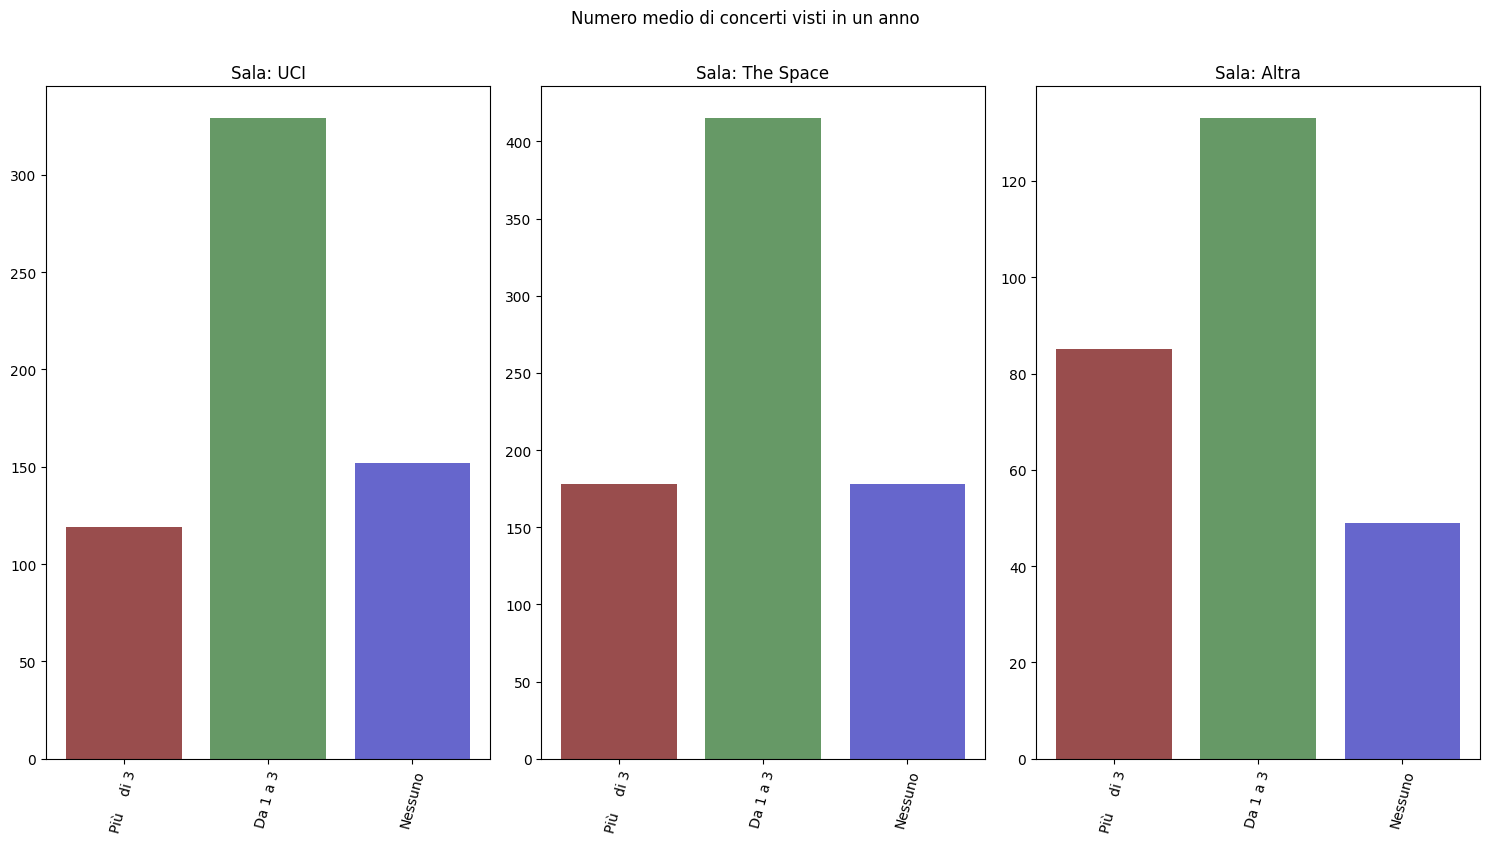

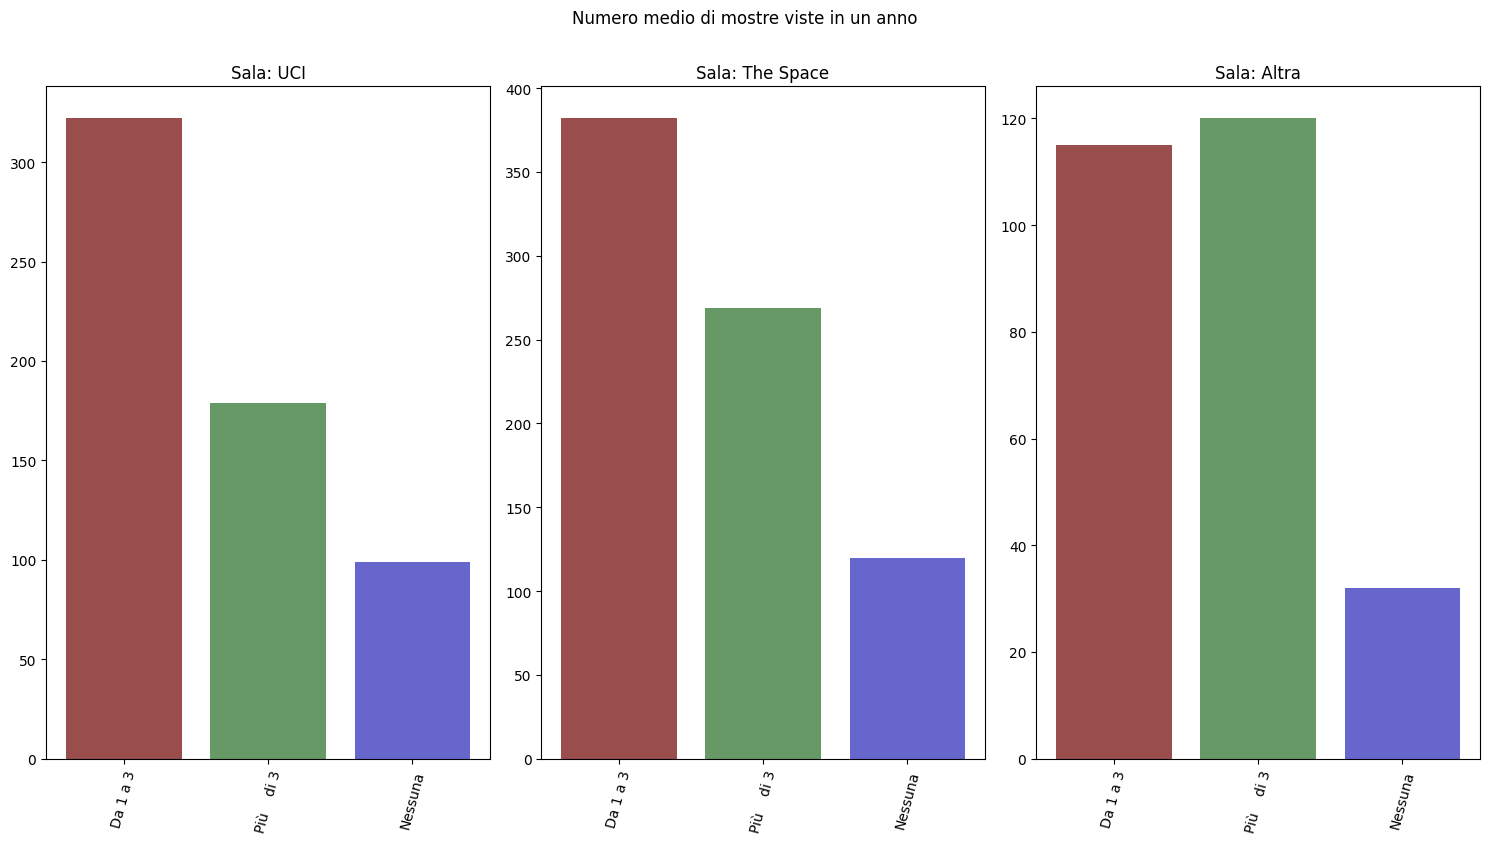

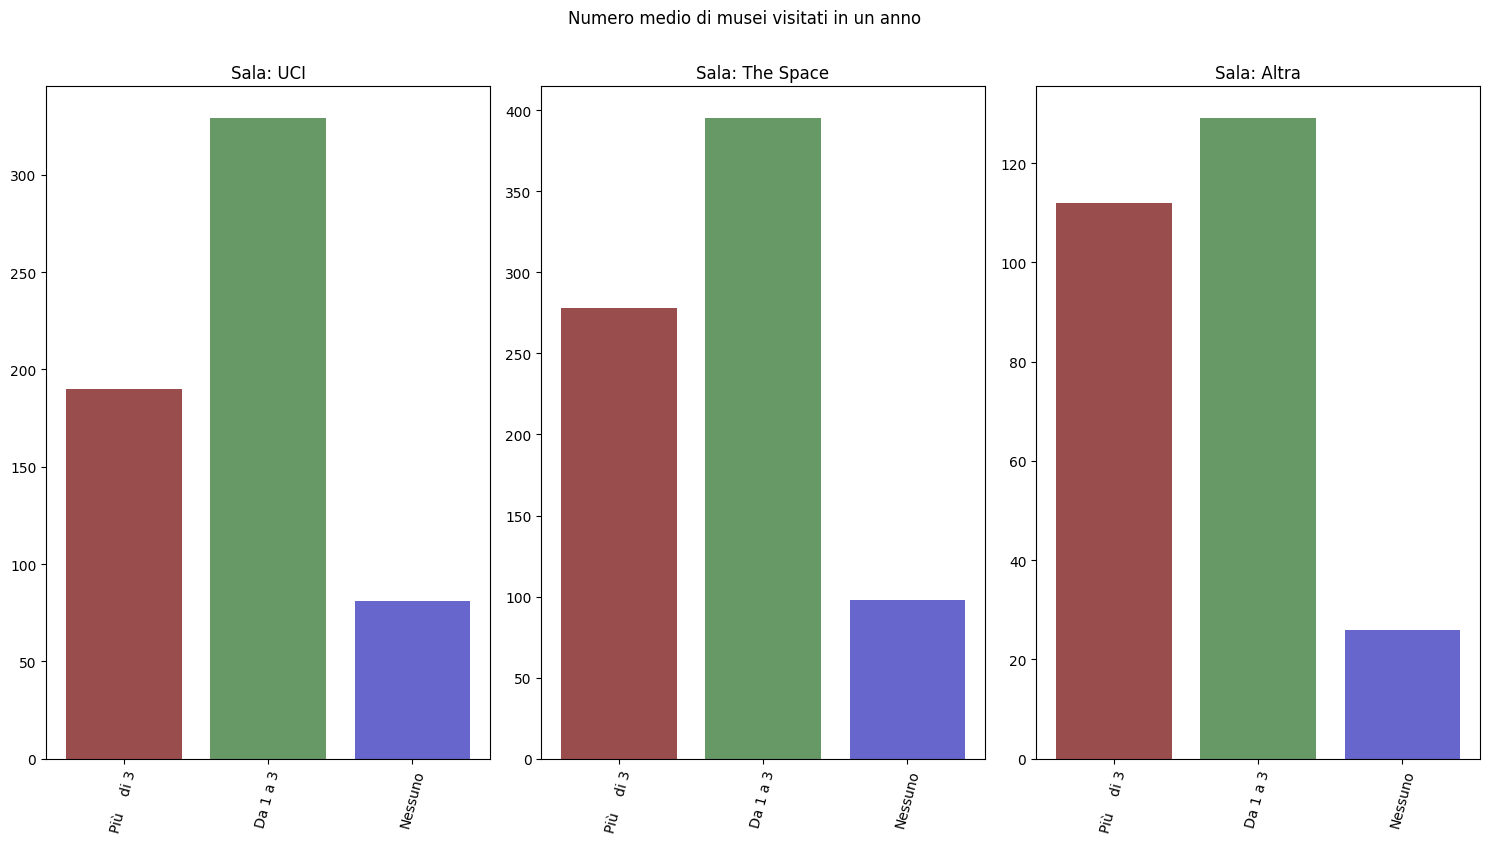

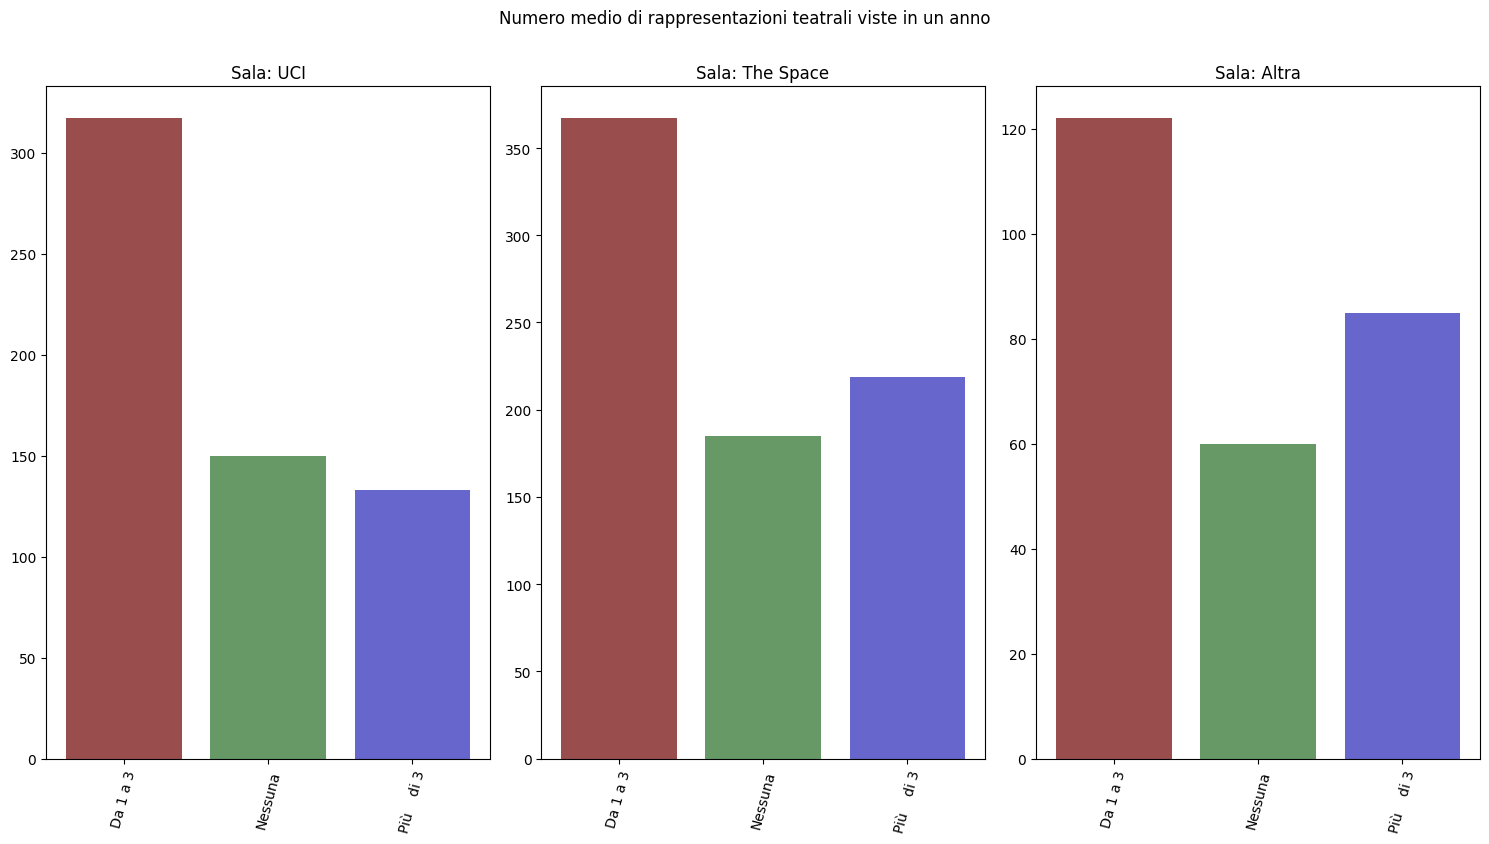

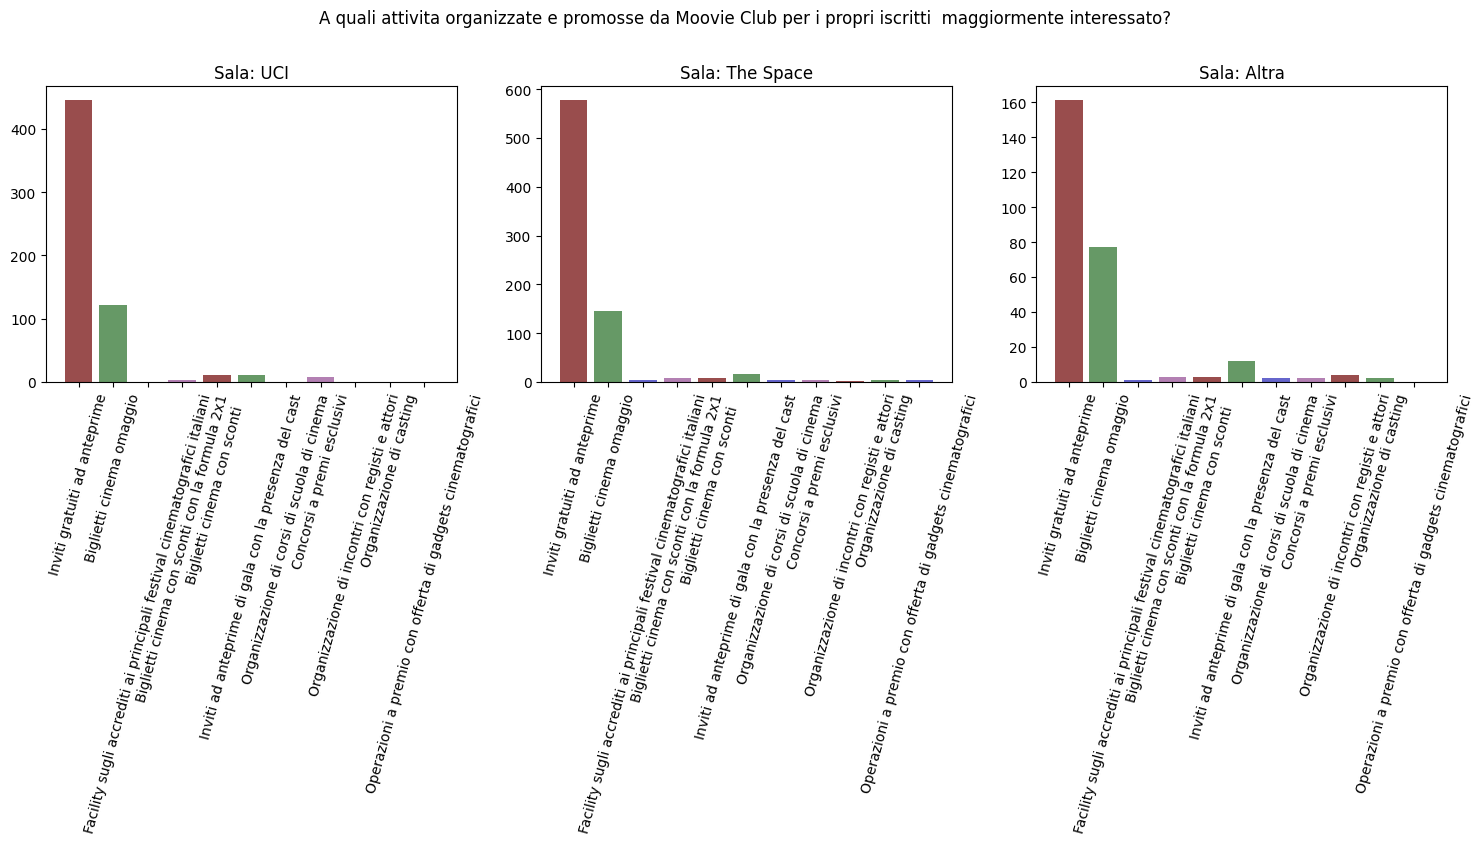

In [18]:
# Plot di una griglia 1x3 dove  mostriamo la distribuzione di tutte le features 
# del campione, categorizzate per la scelta del cinema 
# utile per studiare quali feature influenzano di più la scelta del cinema 
k= 0
while k < len(matrice_somme[0]):
    z = 0
    fig, axs = plt.subplots(1, 3, figsize=(15,8))
    while z < len(matrice_somme):
        altezze = matrice_somme[z][k]
        categorie = lista_stringhe[k]
        colori = [(0.6, 0.3, 0.3), (0.4, 0.6, 0.4), (0.4, 0.4, 0.8), (0.7, 0.5, 0.7)]
        
        axs[z].bar(categorie, altezze, color = colori)
        axs[z].set_title('Sala: %s' % titoli[z])
        #axs[0].set_ylabel(lista_label[k])
        axs[z].tick_params(axis='x', labelrotation=75)
        
        z += 1
    
    k += 1
    plt.tight_layout()
    fig.suptitle(lista_label[k-1], fontsize=12, y = 1.05)
    plt.show()

### Modelli predittivi 

In [19]:
train_data = ds_cin

Encoding nominal categories (without assuming any order)

In [20]:
# Per creare un modello predittivo più efficacie dell'analisi manuale
# dobbiamo tradurre le variabili categoriche del dataset 
# in modo che il modello possa utilizzarle.
# Un modo pratico è usare l'encoding di scikit

# prima visualizziamo le categorie delle varibili 
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(train_data)

In [21]:
data_categorical = train_data[categorical_columns]

In [22]:
# Dobbiamo codificare ogni colonna con dei valori interi specifici
# proviamo con i siti internet maggiormente frequentati.
# Usiamo OrdinalEncoder perchè è una buona startegia per i tree-based models.
site_column = data_categorical[['Siti internet frequentati maggiormente']]

encoder = OrdinalEncoder().set_output(transform='pandas')
site_encoded = encoder.fit_transform(site_column)
site_encoded.head()

,Siti internet frequentati maggiormente
0,2.0
1,1.0
2,1.0
3,2.0
4,0.0


In [23]:
# Ora applichiamo l'encoding a tutto il dataset 
print(f'The dataset is composed of {data_categorical.shape[1]} features')

The dataset is composed of 24 features


In [24]:
data_encoded = encoder.fit_transform(data_categorical)

Splitting Dataset

In [25]:
# splittiamo il dataset per creare un modello predittivo
feature_cols = ['Genere', 'Eta media','Stato civile','Titolo di studio', 'Attivita lavorativa', 'Numero dei componenti nucleo familiare', 
                'Siti internet frequentati maggiormente','Canali social frequentati abitualmente','Mezzi di informazione utilizzati in prevalenza',
                'Principali hobby','Genere di film preferito',
                'Criterio di scelta della sala cinematografica', 'Numero medio di film visti al cinema ogni mese',
                'Abitualmente va al cinema', 'Influiscono sulla scelta dei film','Fonte principale di reperimento informazioni sui film',
                'Oltre che al cinema, preferisce vedere i film', 'Numero medio di libri letti in un anno',
                'Numero medio di concerti visti in un anno', 'Numero medio di mostre viste in un anno',
                'Numero medio di musei visitati in un anno', 'Numero medio di rappresentazioni teatrali viste in un anno',
                'A quali attivita organizzate e promosse da Moovie Club per i propri iscritti  maggiormente interessato?']
#feature_cols = ['Criterio di scelta della sala cinematografica','Numero medio di film visti al cinema ogni mese',
                #'Canali social frequentati abitualmente', 'A quali attivita organizzate e promosse da Moovie Club per i propri iscritti  maggiormente interessato?','Mezzi di informazione utilizzati in prevalenza']

X = data_encoded[feature_cols] # features 
y = data_encoded['Sala cinematografica di riferimento']
# split the dataset into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

### Random Forest: prediction pourpose 

In [61]:
# Mapping per discretizzare il predittore dopo l'encoding
mapping = {0: 'Altra', 1: 'The Space', 2: 'UCI'}
out_y_test = y_test.replace(mapping)
out_y_test.to_csv('out_y_test.csv', index = False)

In [62]:
# implementiamo un modello di classificazione per cercare pattern più complessi
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

output = pd.DataFrame({'ID': X_test.index, 'Sala cinematografica prevista': predictions})
mapping = {0: 'Altra', 1: 'The Space', 2: 'UCI'}
output['Sala cinematografica prevista'] = output['Sala cinematografica prevista'].replace(mapping)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [64]:
# Calcolare diverse metriche di valutazione
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average=None)
confusion = confusion_matrix(y_test, predictions)

# Stampa le metriche
print(f'Accuracy: {accuracy}\n')
print(f'Precision: {precision}\n')
print(f'Recall: {recall}\n')
print(f'F1-Score: {f1}\n')
print(f'Confusion Matrix:\n{confusion}\n')

# Eseguire la cross-validation per ottenere una stima più robusta delle prestazioni
cv_scores = cross_val_score(model, X_train, y_train, cv=10)  # 10-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}\n')
print(f'Cross-Validation Mean Score: {cv_scores.mean()}\n')

Accuracy: 0.5213414634146342

Precision: 0.6755775577557755

Recall: 0.5213414634146342

F1-Score: [0.01904762 0.64173703 0.3968254 ]

Confusion Matrix:
[[  1  86  17]
 [  0 266  58]
 [  0 153  75]]

Cross-Validation Scores: [0.47474747 0.4040404  0.45918367 0.43877551 0.5        0.32653061
 0.43877551 0.48979592 0.46938776 0.51020408]

Cross-Validation Mean Score: 0.4511440940012369



Precisione = Veri positivi / (Veri positivi + Falsi Negativi)

Richiamo o Sensibilità = Veri negativi / (Veri negativi + Falsi Positivi)

### Decision Tree: didatic pourpose 

In [57]:
# Voglio vedere il percorso in un normale Decision Tree, per farmi un'idea delle 
# domande più impattanti sulla predizione:
# per farlo plotto l'output del modello secondo il criterio di Gini Impurity
clf = DecisionTreeClassifier(criterion='gini', random_state=1, max_depth=5, min_samples_split=150)
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Accurancy: 0.4740853658536585


In [ ]:
# Osserviamo l'accuratezza del modello didattico
print('Accurancy:', metrics.accuracy_score(y_test, predictions))

In [56]:
# analizziamo la profondità dell'albero decisionale
clf.get_depth()

5

In [33]:
# parametri del modello
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 150,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

[Text(0.47058823529411764, 0.9166666666666666, 'x[11] <= 2.5\ngini = 0.622\nsamples = 982\nvalue = [163, 447, 372]'),
 Text(0.23529411764705882, 0.75, 'x[19] <= 1.5\ngini = 0.632\nsamples = 412\nvalue = [77, 153, 182]'),
 Text(0.11764705882352941, 0.5833333333333334, 'x[22] <= 1.5\ngini = 0.592\nsamples = 261\nvalue = [31, 101, 129]'),
 Text(0.058823529411764705, 0.4166666666666667, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(0.17647058823529413, 0.4166666666666667, 'x[8] <= 1.5\ngini = 0.591\nsamples = 256\nvalue = [31, 96, 129]'),
 Text(0.11764705882352941, 0.25, 'x[5] <= 0.5\ngini = 0.578\nsamples = 155\nvalue = [21, 48, 86]'),
 Text(0.058823529411764705, 0.08333333333333333, 'gini = 0.654\nsamples = 26\nvalue = [7, 11, 8]'),
 Text(0.17647058823529413, 0.08333333333333333, 'gini = 0.54\nsamples = 129\nvalue = [14, 37, 78]'),
 Text(0.23529411764705882, 0.25, 'gini = 0.583\nsamples = 101\nvalue = [10, 48, 43]'),
 Text(0.35294117647058826, 0.5833333333333334, 'x[11] <= 1.5\ngi

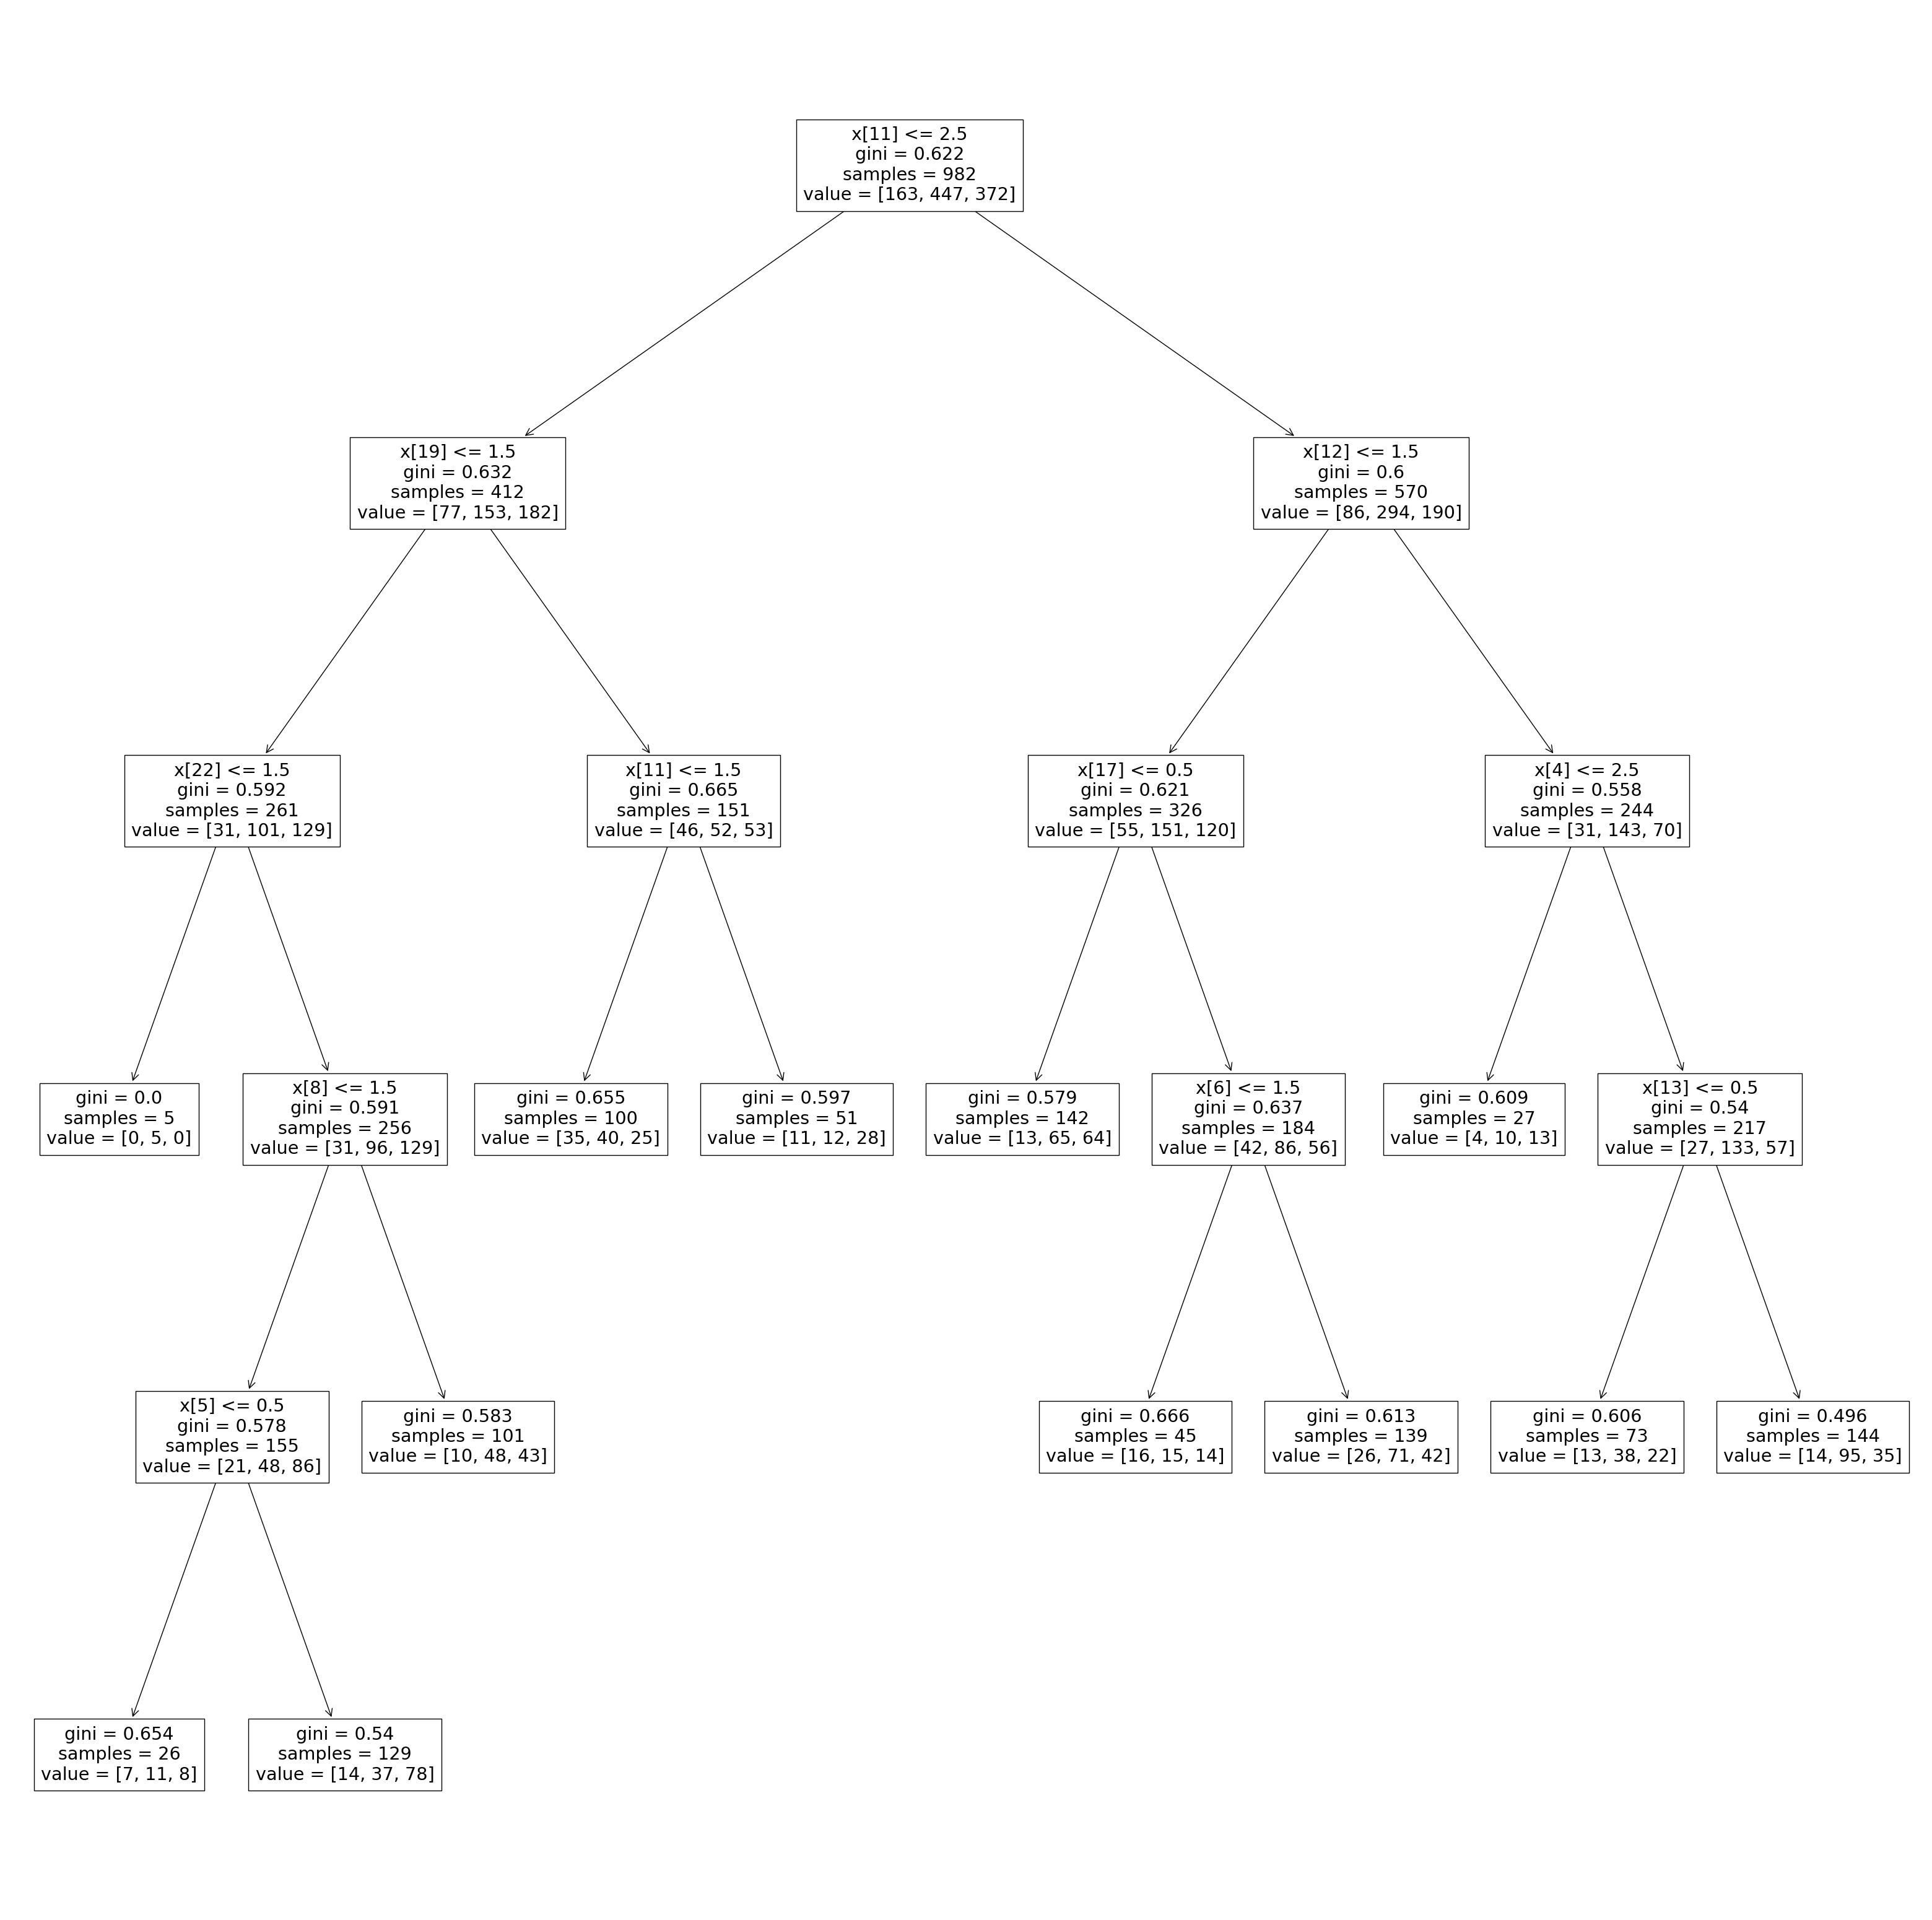

In [58]:
# plottiamo il grafico del Decision Tree
plt.figure(figsize=(40,40))
plot_tree(clf)

In [35]:
# Versione testo_output rappresentazione Decision Tree
tree_rules = export_text(clf, feature_names=feature_cols)
print(tree_rules)

|--- Criterio di scelta della sala cinematografica <= 2.50
|   |--- Numero medio di mostre viste in un anno <= 1.50
|   |   |--- A quali attivita organizzate e promosse da Moovie Club per i propri iscritti  maggiormente interessato? <= 1.50
|   |   |   |--- class: 1.0
|   |   |--- A quali attivita organizzate e promosse da Moovie Club per i propri iscritti  maggiormente interessato? >  1.50
|   |   |   |--- Mezzi di informazione utilizzati in prevalenza <= 1.50
|   |   |   |   |--- Numero dei componenti nucleo familiare <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Numero dei componenti nucleo familiare >  0.50
|   |   |   |   |   |--- class: 2.0
|   |   |   |--- Mezzi di informazione utilizzati in prevalenza >  1.50
|   |   |   |   |--- class: 1.0
|   |--- Numero medio di mostre viste in un anno >  1.50
|   |   |--- Criterio di scelta della sala cinematografica <= 1.50
|   |   |   |--- class: 1.0
|   |   |--- Criterio di scelta della sala cinematografica >  1.50
|  